## Feature Level Misalignment
---

In [17]:
import pandas as pd
import sys, os, json, s3fs
import matplotlib.pyplot as plt
plt.style.use("seaborn")
sys.path.insert(1, "../../")

import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
prod_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod.parquet"
dev_path = "../../data/combined_all_features/combined_1631827665.feather"

prod_df = pd.read_parquet(prod_path)
dev_df = pd.read_feather(dev_path)

#### Preprocessing

In [3]:
sample_date = "2021-09-15"
dev_df = dev_df[dev_df.sample_date==pd.Timestamp(sample_date)]

prod_df["last_checked_date"] = pd.to_datetime(prod_df["last_checked_date"])
prod_df["sample_date"] = prod_df["last_checked_date"].dt.date
prod_df = prod_df[prod_df["sample_date"]==pd.Timestamp(sample_date)]

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
dev_df = mu.prep_customer_data(dev_df)

prod_df["user_id"] = prod_df["party_id"]

In [5]:
prod_df.shape, dev_df.shape

((1129952, 58), (1118933, 98))

In [6]:
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,nr_returns_30d,credit_card_loan_amount,transaction_code,age_money_account,fraud_score_1,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,sample_date,user_id
0,3749,2021-08-25 03:36:51.838,2021-09-15 03:47:17.171,2021-09-15 03:47:17.170,2021-09-15 03:47:17.170,"""RG1""","""scheduled""",415.193050,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,4199.0,ACHDW,30.0,NaN,5,-1.0,-1.0,2021-09-15,3749
1,13317,2021-06-09 02:28:21.787,2021-09-15 02:28:10.880,2021-09-15 02:28:10.879,2021-09-15 02:28:10.879,"""RG1""","""scheduled""",404.635070,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,NaN,ACHDW,449.0,0.0300,5,-1.0,-1.0,2021-09-15,13317
2,14192,2020-12-16 03:23:56.753,2021-09-15 02:14:11.971,2021-09-15 02:14:11.970,2021-09-15 02:14:11.970,"""RG2B""","""scheduled""",499.297733,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2B""",...,0.0,19353.0,NONE,686.0,0.1243,0,-1.0,-1.0,2021-09-15,14192
4,32516,2020-11-11 03:46:29.313,2021-09-15 02:16:28.784,2021-09-15 02:16:28.783,2021-09-15 02:16:28.783,"""RG1""","""scheduled""",507.394183,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,0.0,673.0,NONE,745.0,0.0708,0,-1.0,-1.0,2021-09-15,32516
5,33224,2021-08-18 02:05:15.900,2021-09-15 02:07:07.008,2021-09-15 02:07:07.007,2021-09-15 02:07:07.007,"""RG3A""","""scheduled""",576.250640,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG3A""",...,0.0,NaN,NONE,1065.0,0.0468,0,-1.0,-1.0,2021-09-15,33224


In [7]:
dev_df.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,sample_date,is_static,nr_transactions_next_60d,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,party_id,is_active,fico_adjusted,fico_adjusted_pred
2333334,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,2021-09-15,True,0.0,5,-1.0,-1.0,188,False,831.0,-831.0
2333335,2021-07-08 07:35:33,103.0,410002729647,POSDW,-97.94,,1011.81,299,False,None,...,2021-09-15,True,0.0,1,-1.0,-1.0,299,False,799.0,-799.0
2333336,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,2021-09-15,True,0.0,0,-1.0,-1.0,305,False,NaN,NaN
2333337,2021-09-02 04:31:10,135.0,410000345005,ACHDWIN,-15.00,,3607.78,361,False,None,...,2021-09-15,True,1.0,3,-1.0,-1.0,361,True,NaN,NaN
2333338,NaT,159.0,410018394673,None,NaN,None,NaN,419,False,None,...,2021-09-15,True,0.0,0,-1.0,-1.0,419,False,799.0,-799.0


#### Alignment of IDs
---

Overall population

In [8]:
dev_uids = dev_df["user_id"].unique()
prod_uids = prod_df["user_id"].unique()

In [9]:
dev_only = set(dev_uids) - set(prod_uids)
prod_only = set(prod_uids) - set(dev_uids)
shared_uids = set(dev_uids).intersection(set(prod_uids))

In [10]:
len(dev_only), len(prod_only), len(shared_uids)

(9063, 20084, 1109868)

How about the active users? - Nope

In [11]:
dev_df.is_active.value_counts()

False    952687
True     166246
Name: is_active, dtype: int64

In [12]:
active_ids = set(dev_df[dev_df.is_active].user_id.unique())
print(f"num active ids: {len(active_ids)}")
print(f"active ids shared across platforms: {len(active_ids.intersection(shared_uids))}")
print(f"active ids in prod only: {len(active_ids.intersection(prod_only))}")

num active ids: 166245
active ids shared across platforms: 161735
active ids in prod only: 0


### Get Model scores

In [18]:
incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

In [20]:
dev_df = mu.prep_customer_data(dev_df)  # get is_active here
features = incumbent_model.feature_name_
dev_df["model_score"] = incumbent_model.predict_proba(dev_df[features])[:,1]
dev_df["model_score"] = mu.scale_scores(dev_df["model_score"])

# get risk groups for the dev env
dev_df["risk_group_dev"] = get_risk_groups(dev_df["model_score"])
prod_df["risk_group_dev"] = get_risk_groups(prod_df["model_score"])

#### Full Population

In [22]:
# exact match percentage?
combined_df = get_combined_dfs(dev_df, prod_df, index_col="user_id")

In [23]:
combined_df.head()

,transaction_datetime_exp,borrower_id_exp,business_account_number_exp,transaction_code_exp,transaction_amount_exp,external_account_number_exp,real_ending_balance_exp,user_id,sofi_employee_ind_exp,dtc_exp,...,nr_returns_30d_act,credit_card_loan_amount_act,transaction_code_act,age_money_account_act,fraud_score_1_act,transaction_code_encoded_act,all7120_default_encoded_act,bcc7120_default_encoded_act,sample_date_act,risk_group_dev_act
0,2019-06-17 18:01:13,44.0,410000434669,ACHDW,-10.09,1023025883,0.00,188,False,None,...,0.0,3338.0,NONE,NaN,0.0262,0,-1.0,-1.0,2021-09-15,RG4
1,2021-07-08 07:35:33,103.0,410002729647,POSDW,-97.94,,1011.81,299,False,None,...,0.0,4665.0,POSDW,726.0,0.4227,1,-1.0,-1.0,2021-09-15,RG1
2,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,0.0,NaN,NONE,1039.0,0.0207,0,-1.0,-1.0,2021-09-15,RG4
3,2021-09-02 04:31:10,135.0,410000345005,ACHDWIN,-15.00,,3607.78,361,False,None,...,0.0,NaN,ACHDWIN,1007.0,NaN,3,-1.0,-1.0,2021-09-15,RG2
4,NaT,159.0,410018394673,None,NaN,None,NaN,419,False,None,...,0.0,580.0,NONE,14.0,NaN,0,-1.0,-1.0,2021-09-15,RG3


In [24]:
df_ = combined_df[["user_id", "business_account_number_exp", "model_score_exp", "model_score_act"]]

In [25]:
# 15504149, 13834008  occured twice
display(df_[df_.user_id.isin([15504149, 13834008])])

# why two business account number?
# we dropped primary account owners 
df_ = df_[~df_.business_account_number_exp.isin([410001722493, 410014348707])]
display(df_[df_.user_id.isin([15504149, 13834008])])

,user_id,business_account_number_exp,model_score_exp,model_score_act
108871,13834008,410001722493,446.313428,537.370873
108872,13834008,410018816324,523.210422,537.370873
224447,15504149,410014348707,600.234864,687.783278
224448,15504149,410014348716,614.134239,687.783278


,user_id,business_account_number_exp,model_score_exp,model_score_act
108872,13834008,410018816324,523.210422,537.370873
224448,15504149,410014348716,614.134239,687.783278


In [26]:
# this is the exact alignment arpit is talking about
display((df_.model_score_exp == df_.model_score_act).value_counts(normalize=True))

False    0.989589
True     0.010411
dtype: float64

### By Features

In [72]:
import numpy as np
import pandas as pd

def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, title='', fig=None, ax=None):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    ax.hist(seq, alpha=0.6, bins=bins, label='exp - actual')
    ax.set_title(title)
    ax.legend()
    return fig, ax

def plot_score_dist(dev_score, prod_score, figsize=(9,7), 
                    dev_label='development', prod_label='production',
                    bins=10, title='', fig=None, ax=None):
    """ Compare distributions of two scores
    @params dev_score: sequence of scores
    @params prod_score: sequence of scores
    @params figsize: tuple
    @returns fig: plt.figure object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.hist(dev_score, alpha=0.5, bins=bins, label=dev_label)
    ax.hist(prod_score, alpha=0.5, bins=bins, label=prod_label)
    ax.set_title(title)
    ax.legend()
    return fig, ax


(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'nr_past_transactions: differences'}>)

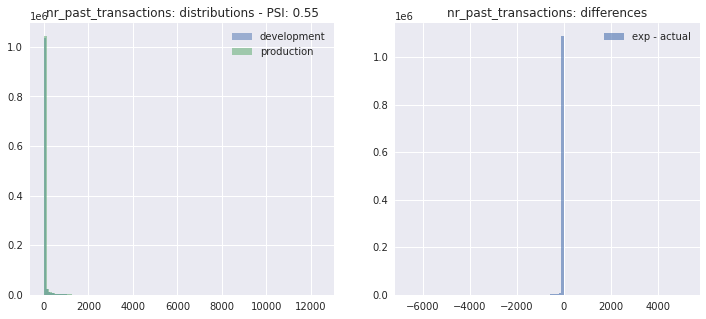

In [74]:
ft = "nr_past_transactions"
ft_dev = ft + "_exp"
ft_prod = ft + "_act"

psi = get_psi(combined_df[ft_dev].rename().to_frame(), 
                         combined_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 2)}")
plot_difference(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[1], title=f"{ft}: differences") 

(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'fraud_score_2: differences'}>)

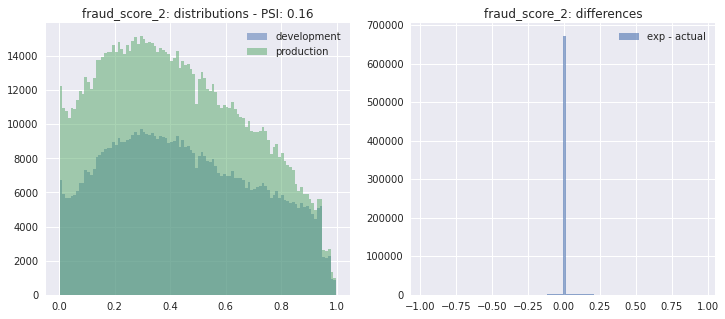

In [75]:
ft = "fraud_score_2"
ft_dev = ft + "_exp"
ft_prod = ft + "_act"

psi = get_psi(combined_df[ft_dev].rename().to_frame(), 
                         combined_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 2)}")
plot_difference(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[1], title=f"{ft}: differences") 

In [76]:
psi_tbl = get_psi(dev_df[features], prod_df[features]).round(2)
display(psi_tbl.head())

,feature,psi
15,nr_past_transactions,0.56
4,fraud_score_2,0.17
6,transaction_as_pct_of_balance,0.11
38,transaction_code_encoded,0.06
26,time_since_last_transaction,0.03


In [77]:
(combined_df[ft_dev] == combined_df[ft_prod]).mean()

0.6038022471100218

In [78]:
def get_alignment(s1, s2):
    same = (s1 == s2).mean()
    one_missing = ((s1.isna() & ~s2.isna()) | (~s1.isna() & s2.isna())).mean()
    return same, one_missing

get_alignment(combined_df[ft_dev], combined_df[ft_prod])

(0.6038022471100218, 0.356088550911368)

### Full Population

In [79]:
# what is the percentage of features that do not align
# also consider closeness!!!
rows = []
for ft in psi_tbl.feature:
    ft_dev = ft + "_exp"
    ft_prod = ft + "_act"
    pct_same, pct_one_missing = get_alignment(combined_df[ft_dev], combined_df[ft_prod])
    row = [ft, pct_same, pct_one_missing]
    rows.append(row)
stats = pd.DataFrame(rows)
stats.columns = ["feature", "pct_same", "pct_one_side_missing"]
stats.set_index("feature", inplace=True)
stats

,pct_same,pct_one_side_missing
feature,,
nr_past_transactions,0.297297,0.000000
fraud_score_2,0.603802,0.356089
transaction_as_pct_of_balance,0.667175,0.000000
transaction_code_encoded,0.861722,0.000000
time_since_last_transaction,0.808160,0.000000
address_risk_score,0.877696,0.005380
name_address_correlation,0.931472,0.020236
giact_nr_decline,0.119074,0.000000
phone_risk_score,0.880236,0.005360


/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


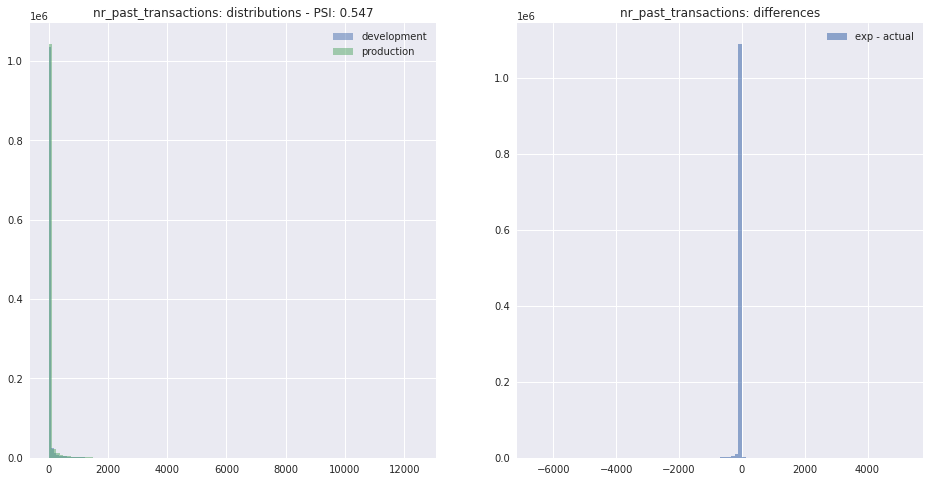

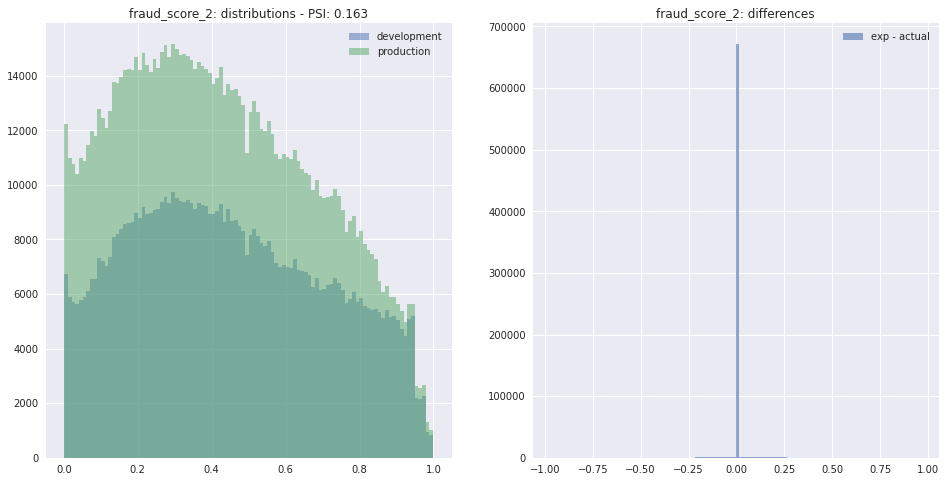

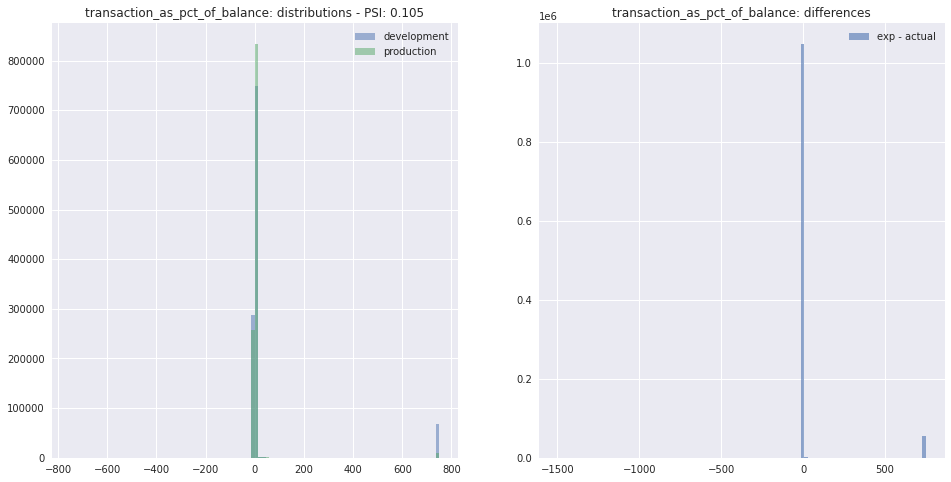

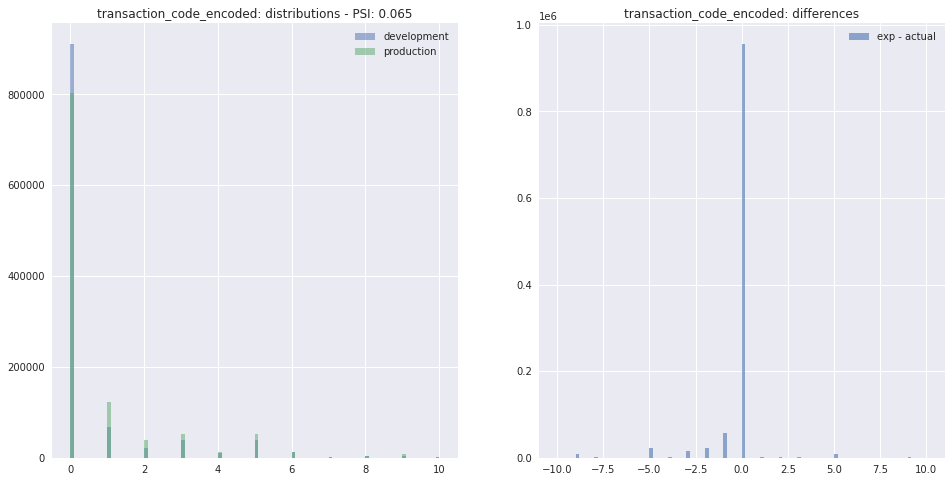

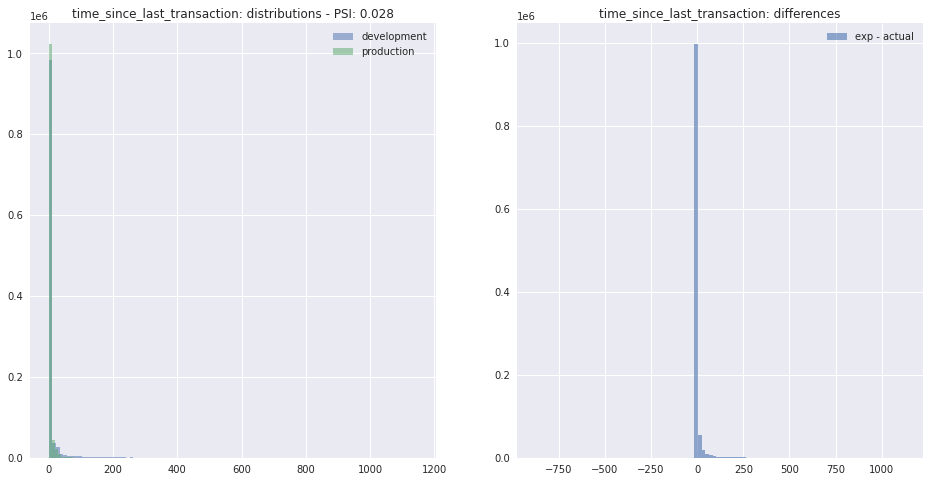

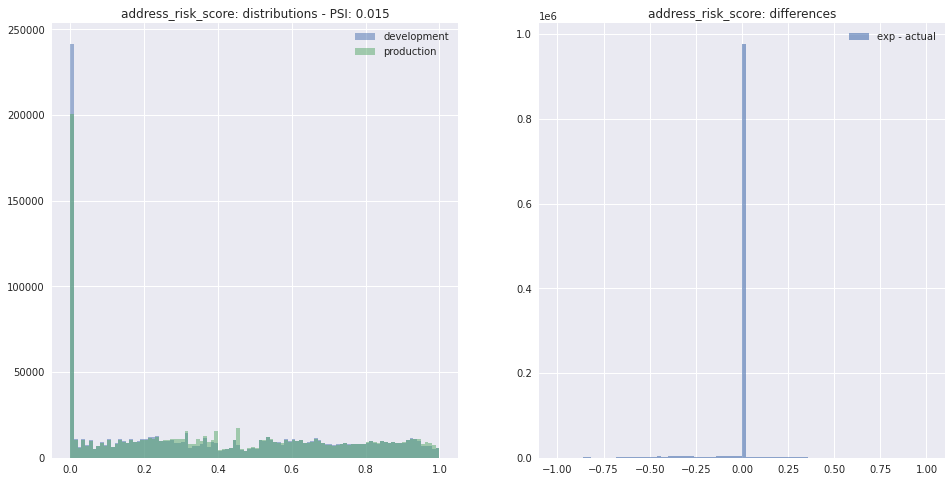

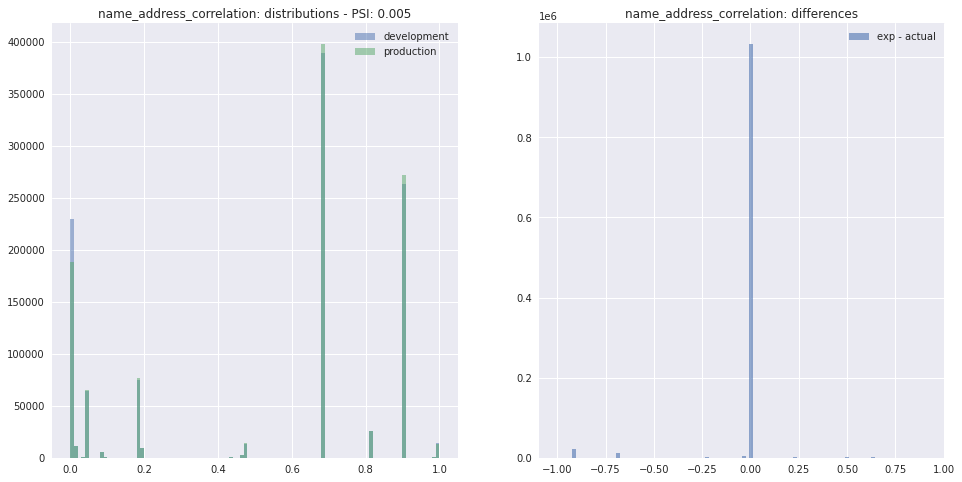

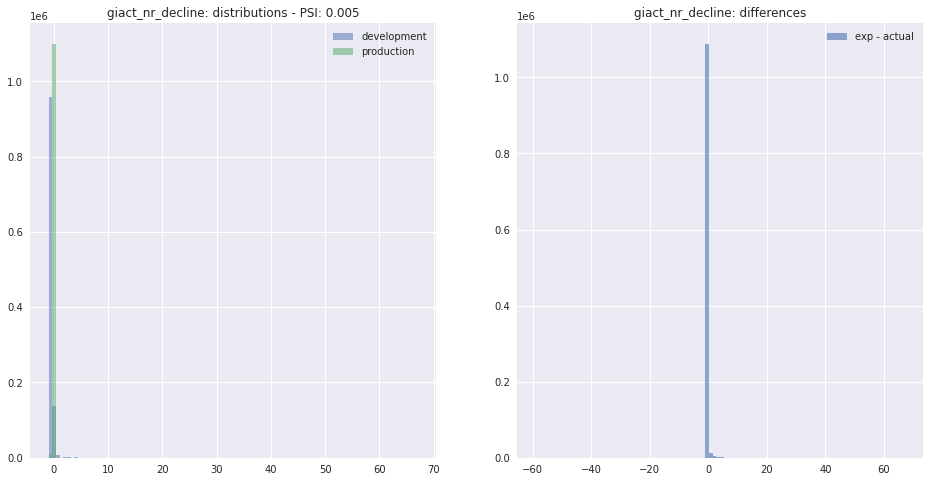

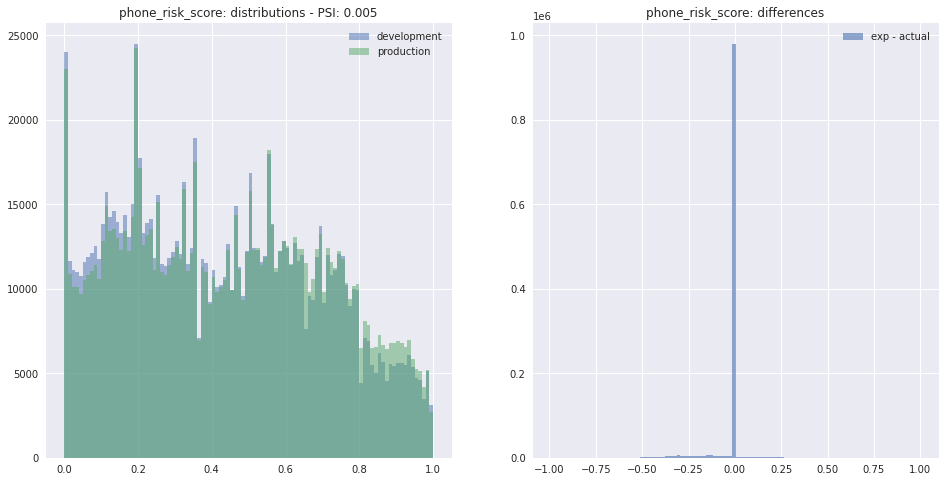

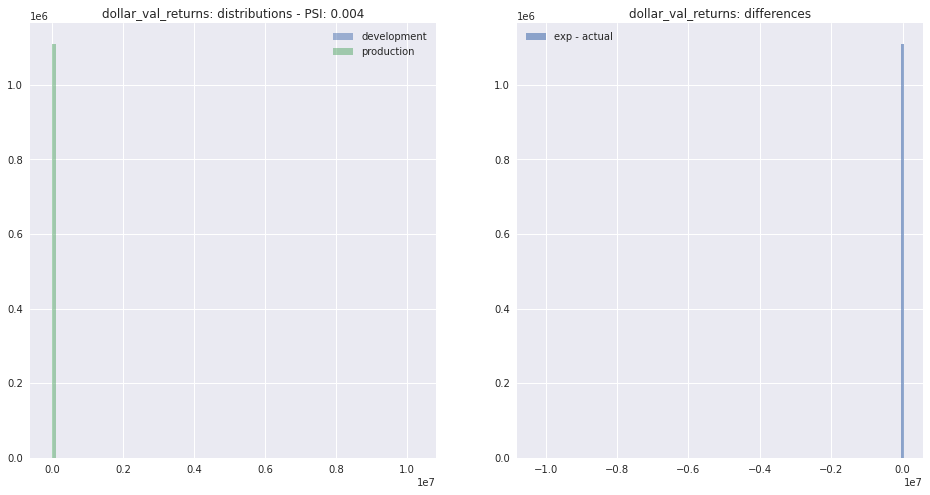

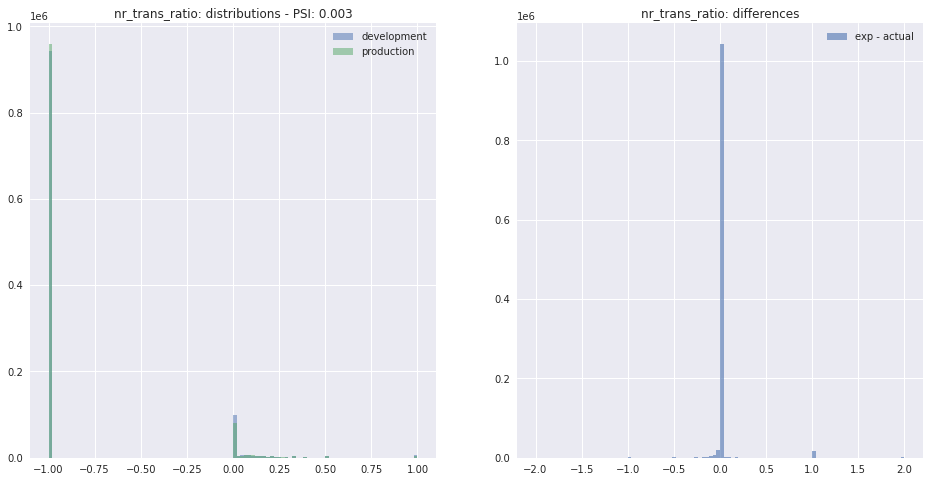

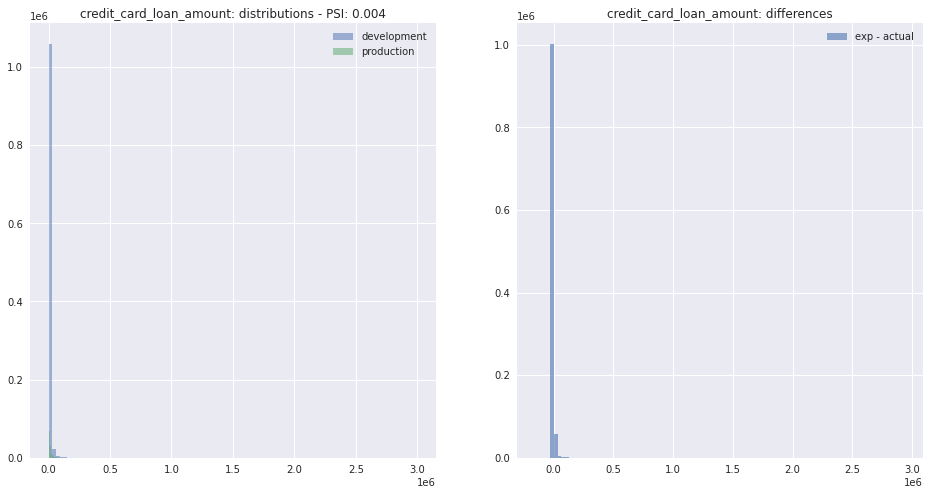

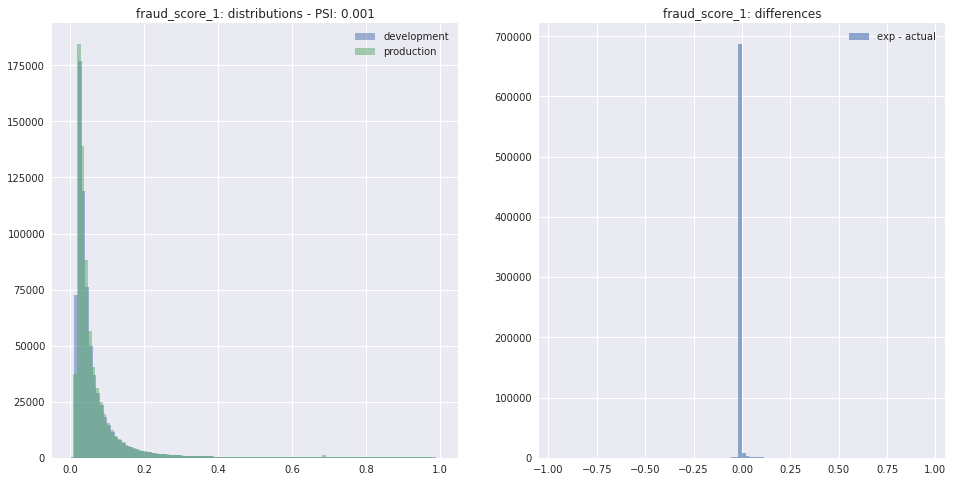

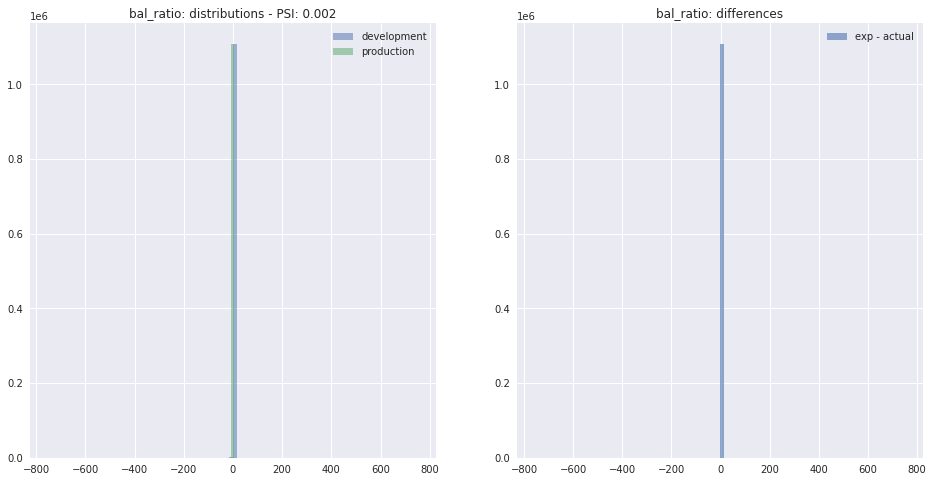

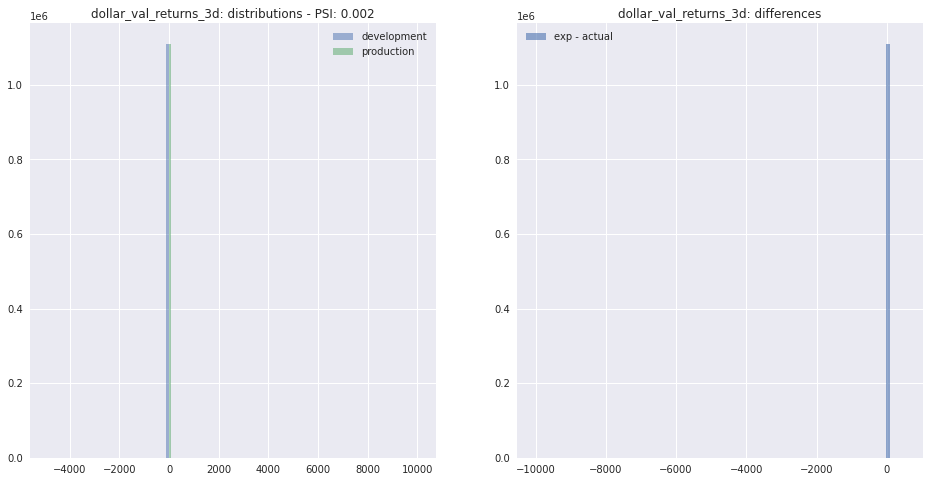

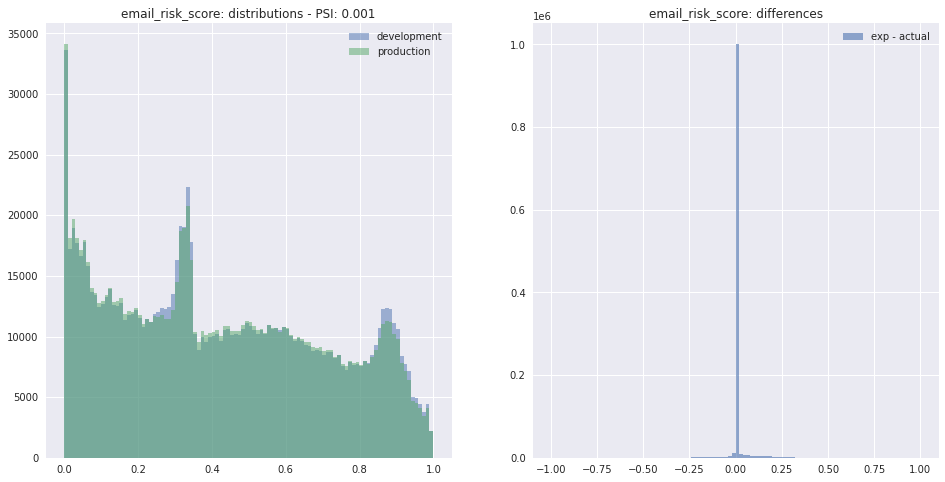

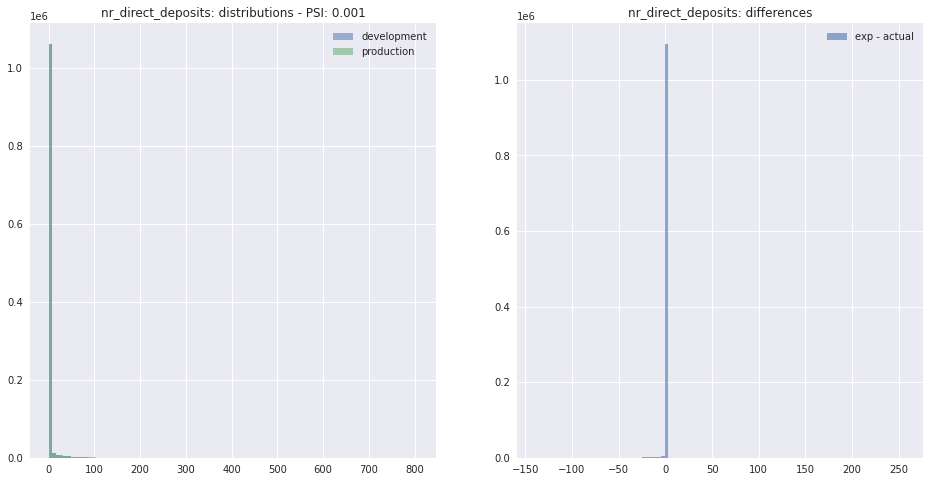

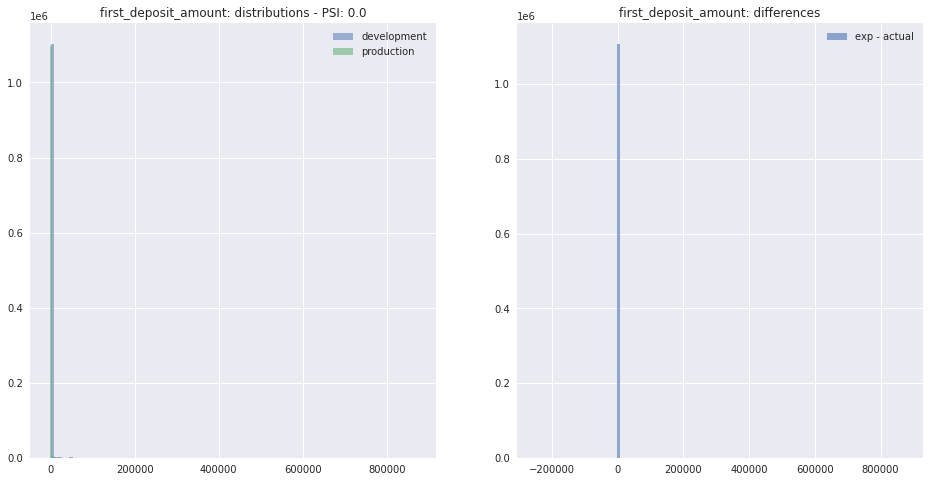

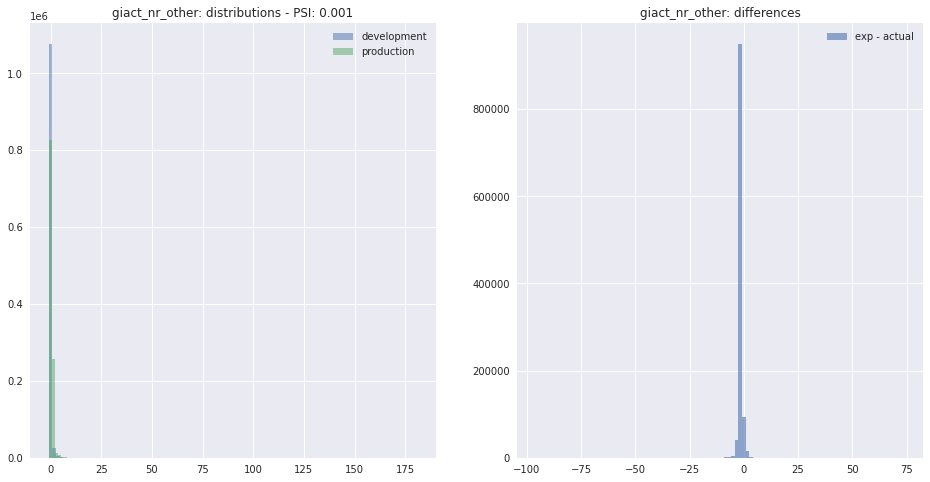

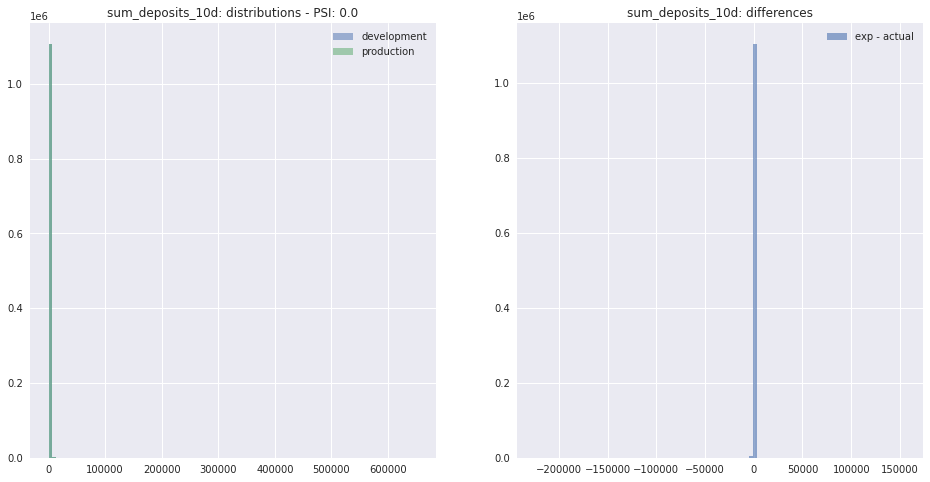

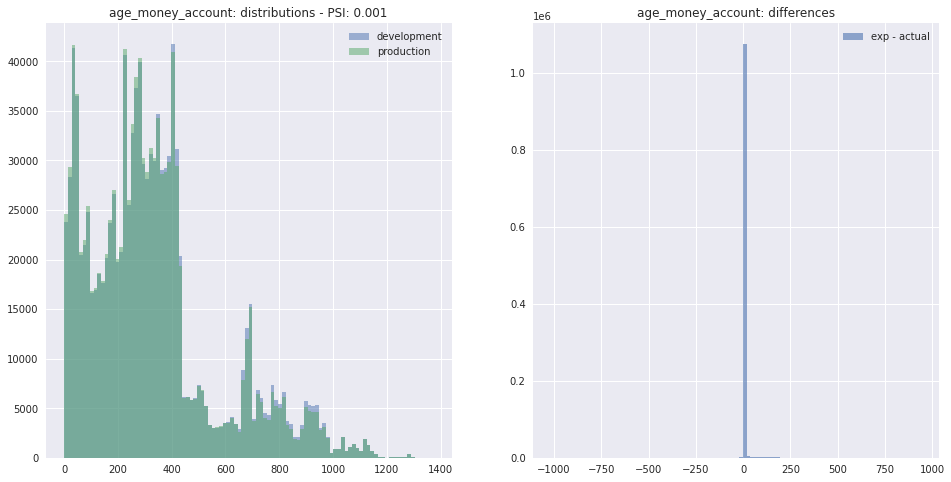

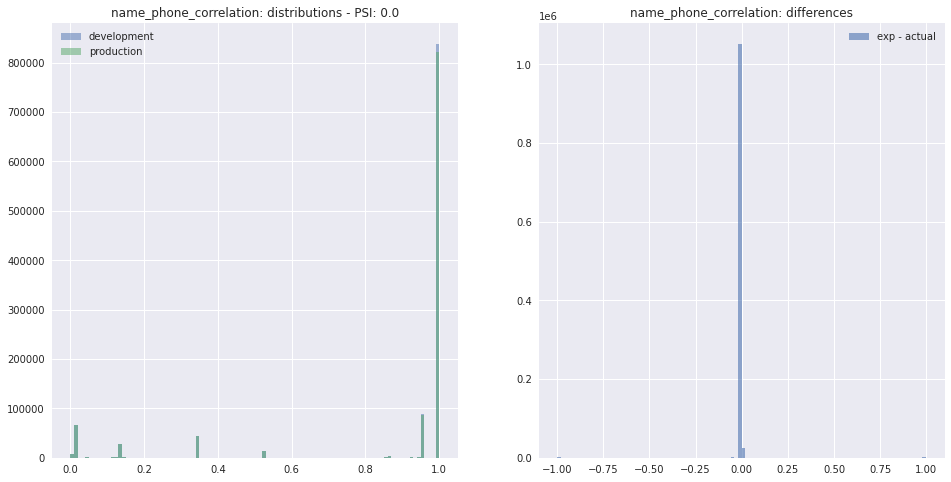

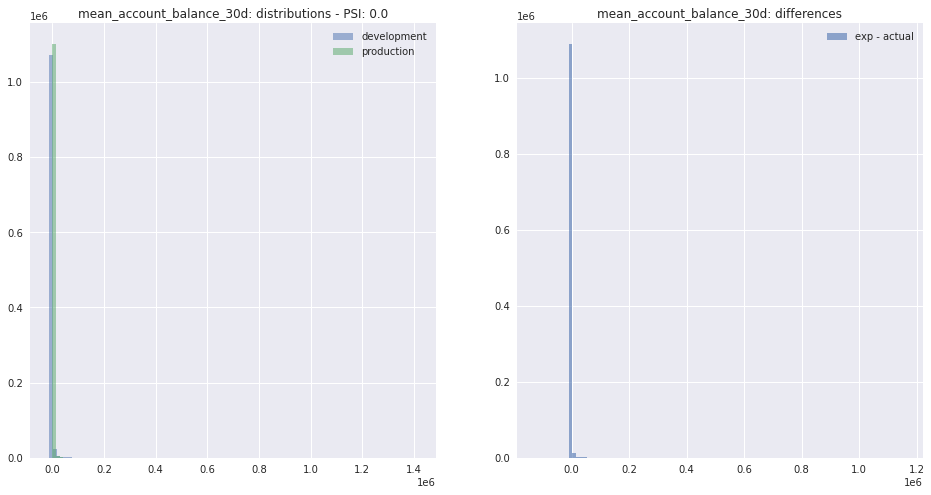

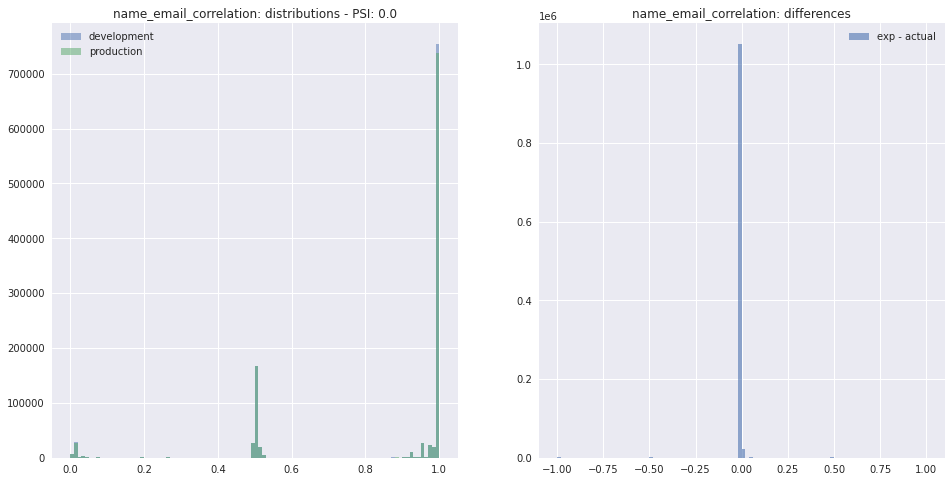

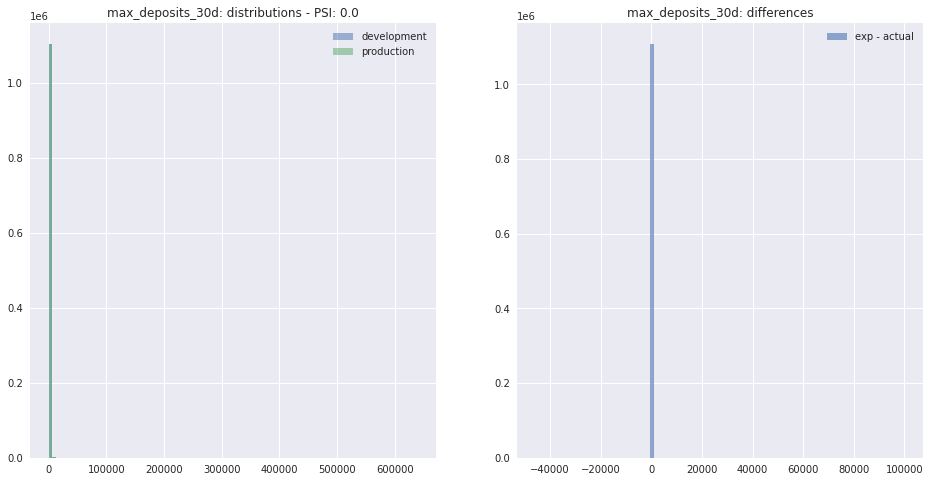

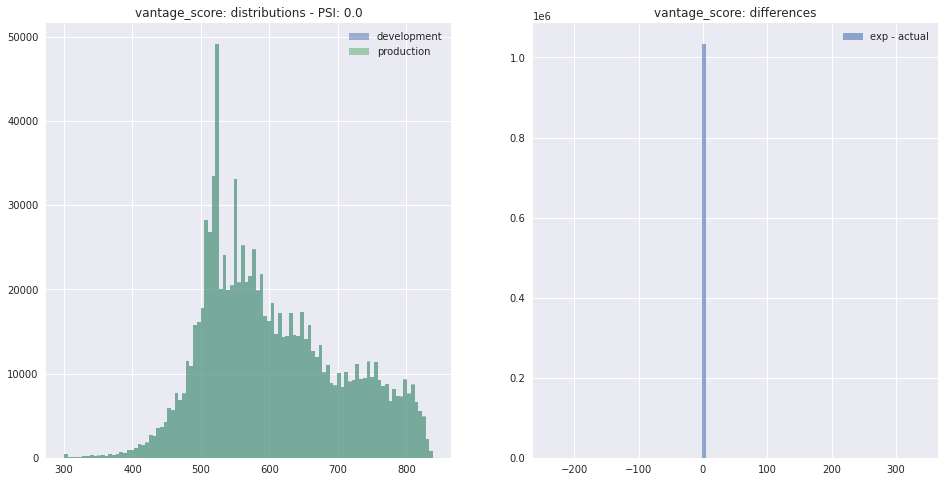

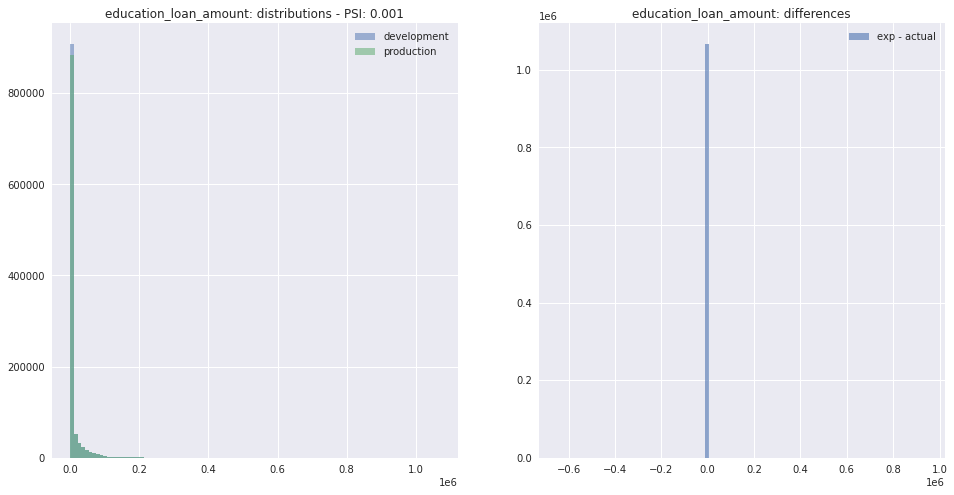

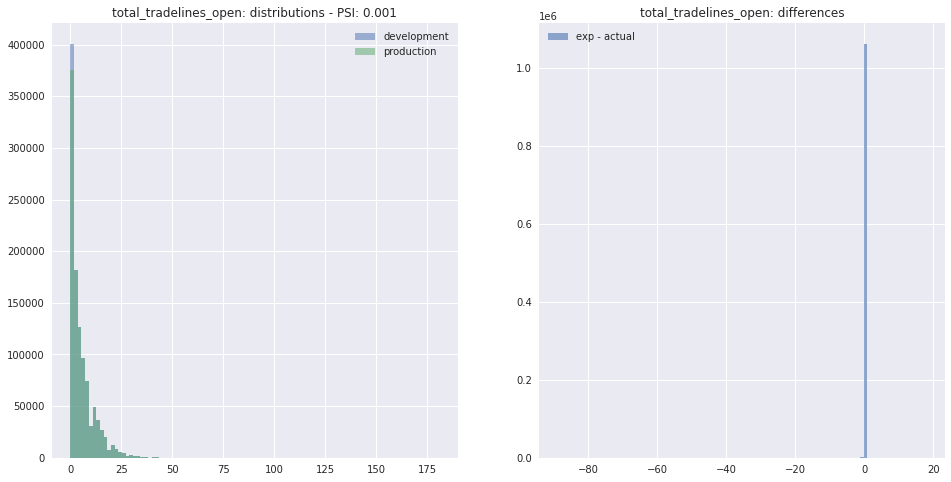

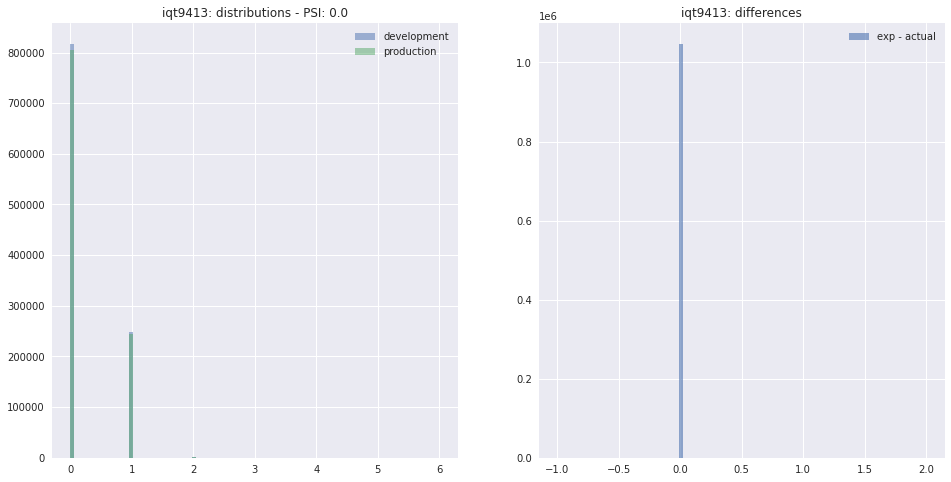

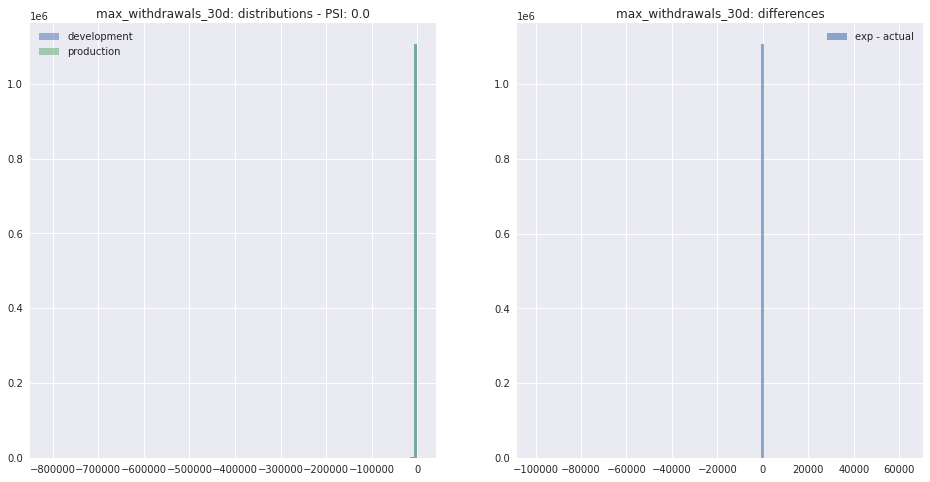

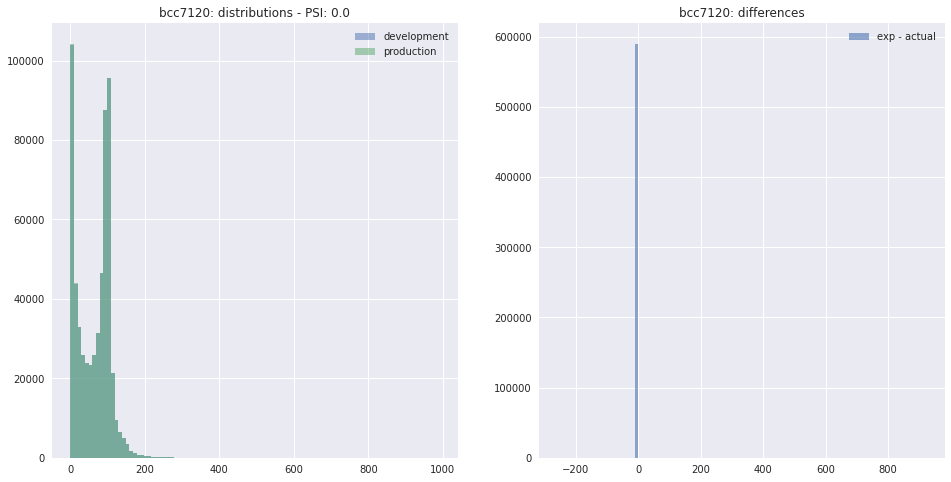

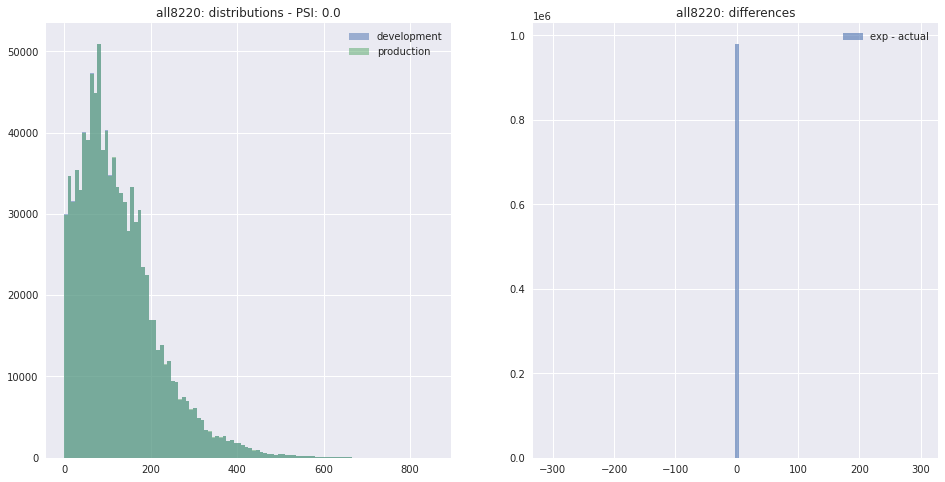

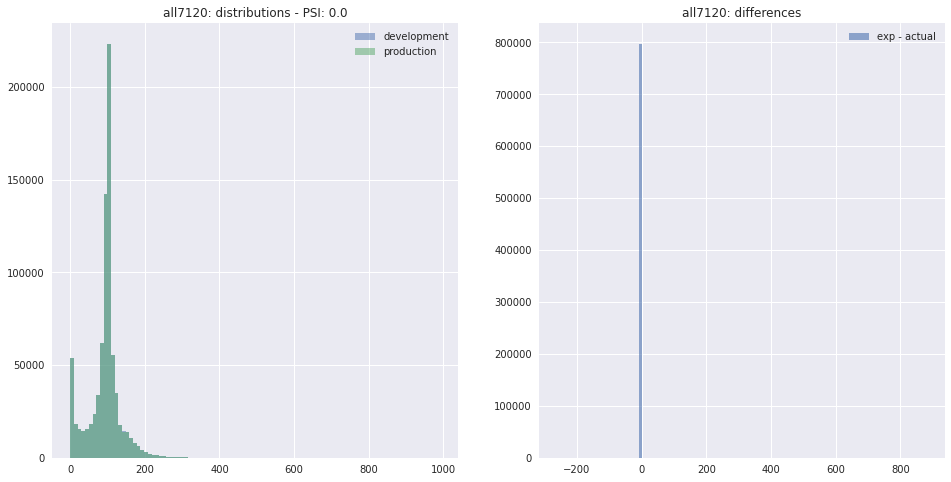

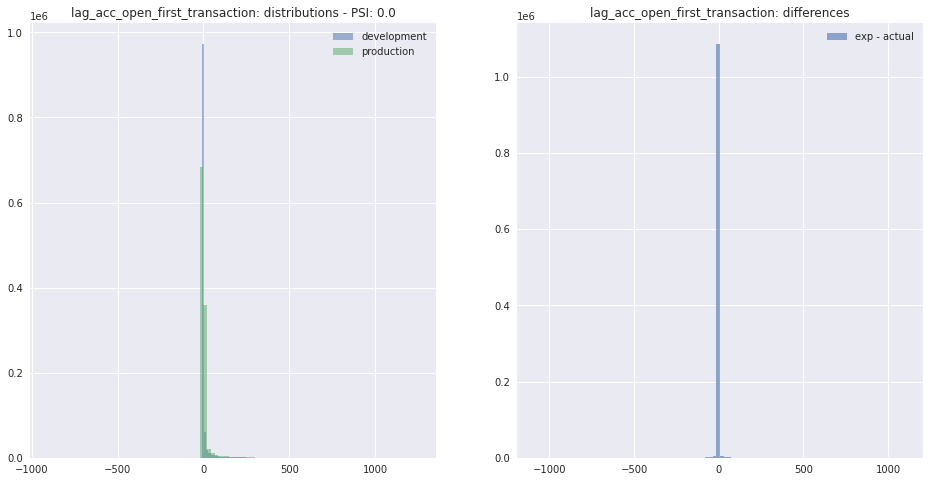

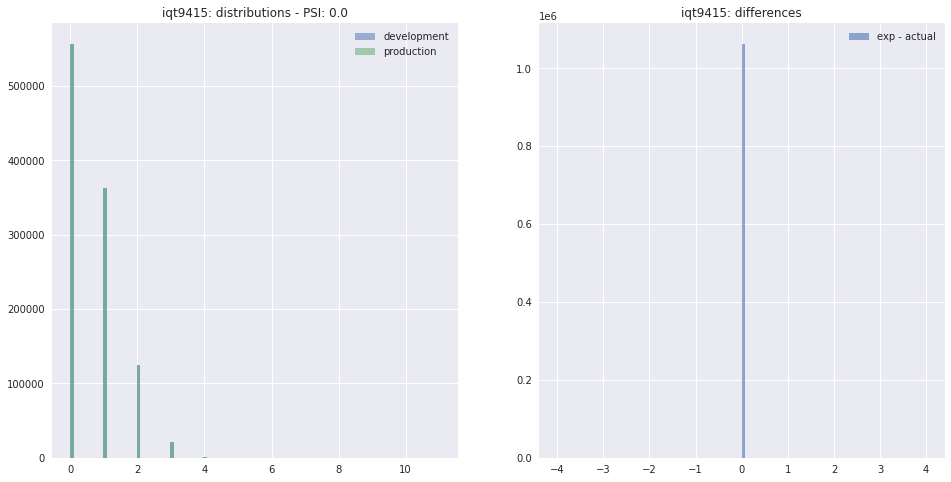

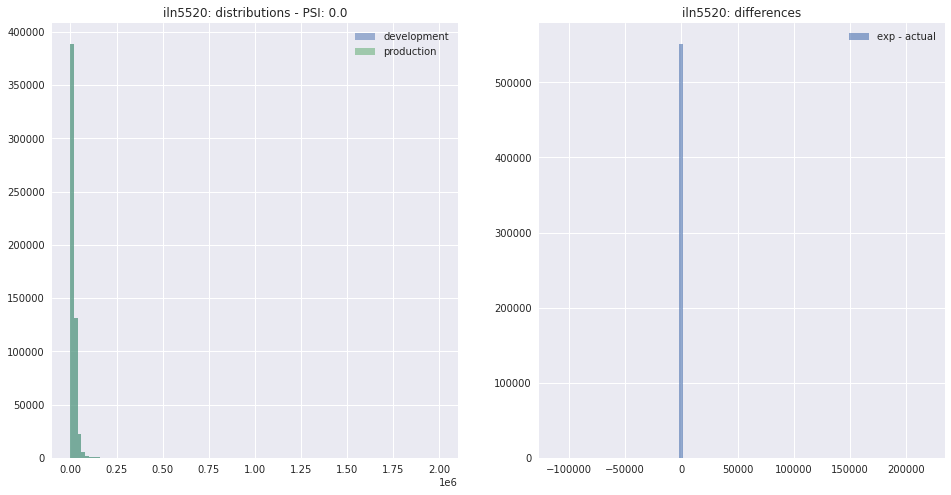

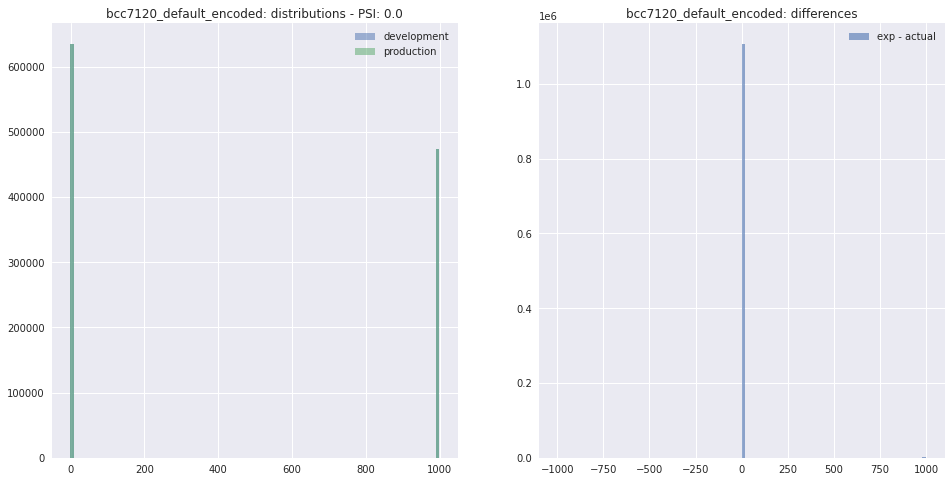

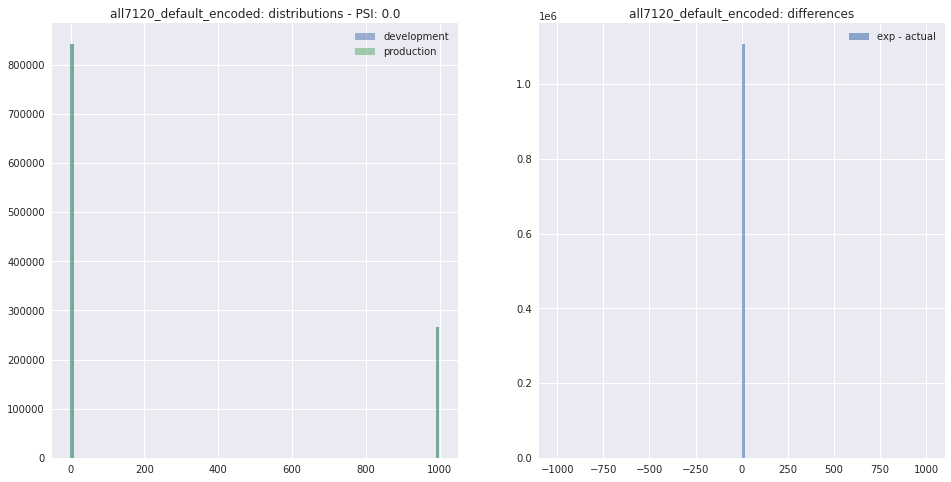

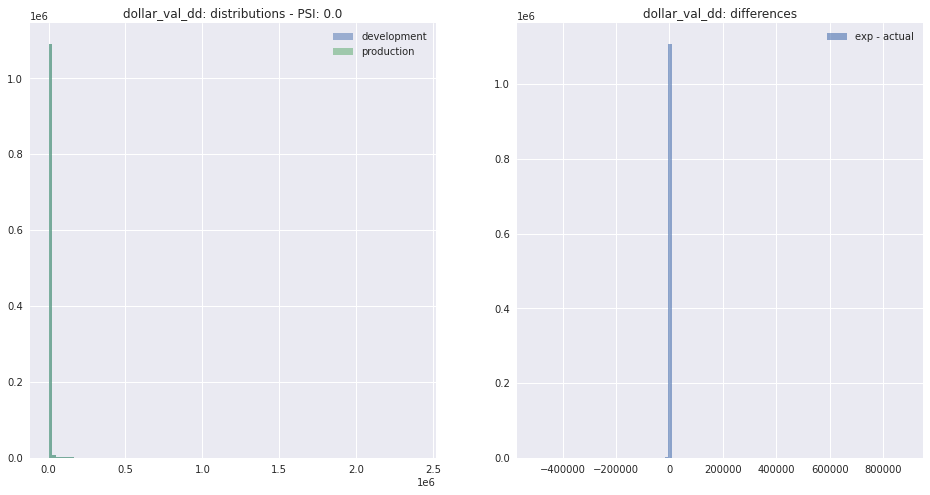

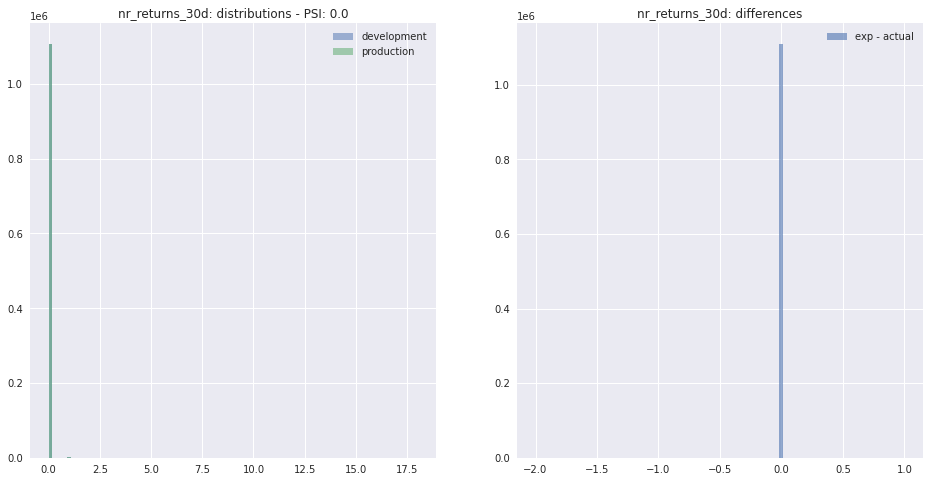

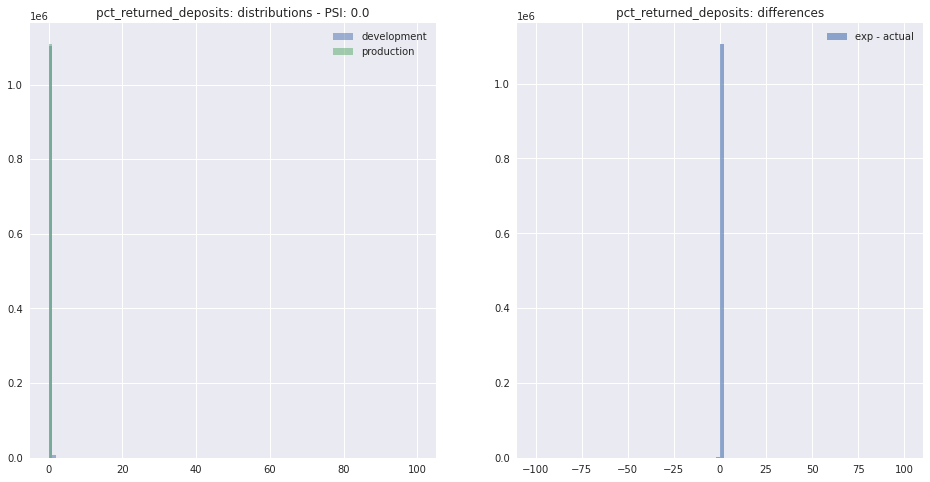

In [80]:
# all
for ft in psi_tbl.feature:
    ft_dev = ft + "_exp"
    ft_prod = ft + "_act"

    psi = get_psi(combined_df[ft_dev].rename().to_frame(), 
                             combined_df[ft_prod].rename().to_frame()).loc[0, "psi"]
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plot_score_dist(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 3)}")
    plot_difference(combined_df[ft_dev], combined_df[ft_prod], bins=100, fig=fig, ax=axs[1], title=f"{ft}: differences") 
    plt.legend()

### Active Accounts

In [81]:
combined_df_active = combined_df[combined_df.is_active_exp]
combined_df_active.shape

(161736, 158)

In [82]:
psi_tbl_active = get_psi(dev_df[dev_df.user_id.isin(active_ids)][features], 
                         prod_df[prod_df.user_id.isin(active_ids)][features]).round(2)
display(psi_tbl_active)

,feature,psi
31,nr_trans_ratio,0.88
4,fraud_score_2,0.51
18,address_risk_score,0.08
6,transaction_as_pct_of_balance,0.05
9,name_address_correlation,0.04
26,time_since_last_transaction,0.02
8,phone_risk_score,0.02
38,transaction_code_encoded,0.02
24,giact_nr_decline,0.02
36,fraud_score_1,0.01


In [83]:
# what is the percentage of features that do not align
rows = []
for ft in psi_tbl.feature:
    ft_dev = ft + "_exp"
    ft_prod = ft + "_act"
    pct_same, pct_one_missing = get_alignment(combined_df_active[ft_dev], combined_df_active[ft_prod])
    row = [ft, pct_same, pct_one_missing]
    rows.append(row)
stats = pd.DataFrame(rows)
stats.columns = ["feature", "pct_same", "pct_one_side_missing"]
stats.set_index("feature", inplace=True)
stats

,pct_same,pct_one_side_missing
feature,,
nr_past_transactions,0.539515,0.000000
fraud_score_2,0.376886,0.566707
transaction_as_pct_of_balance,0.114569,0.000000
transaction_code_encoded,0.922040,0.000000
time_since_last_transaction,0.588156,0.000000
address_risk_score,0.785502,0.004143
name_address_correlation,0.885925,0.004600
giact_nr_decline,0.275845,0.000000
phone_risk_score,0.787574,0.004136


/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


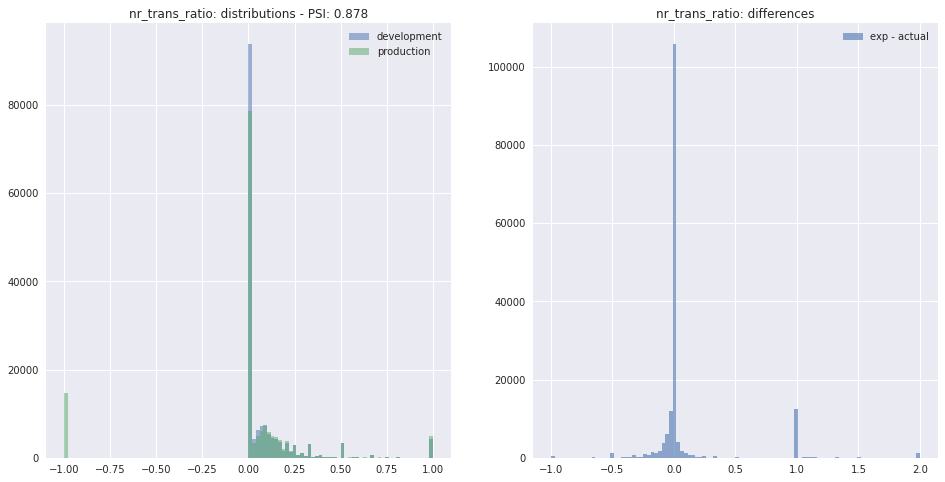

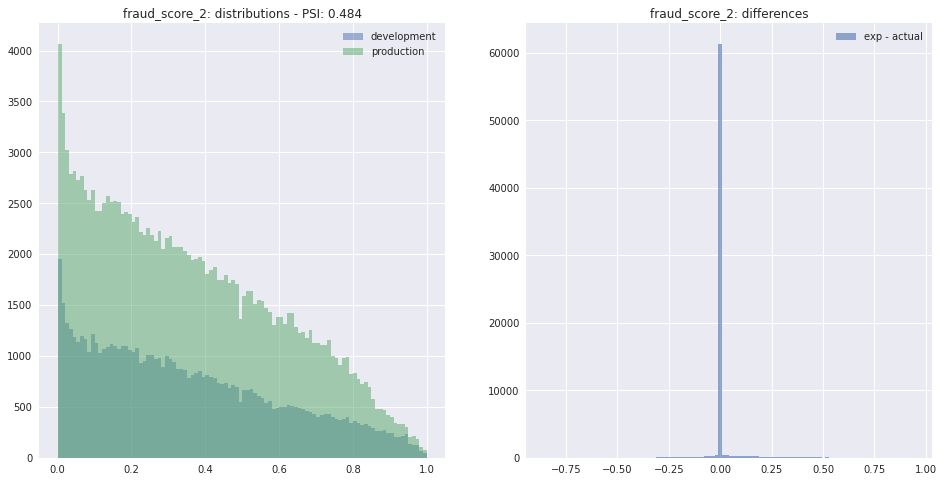

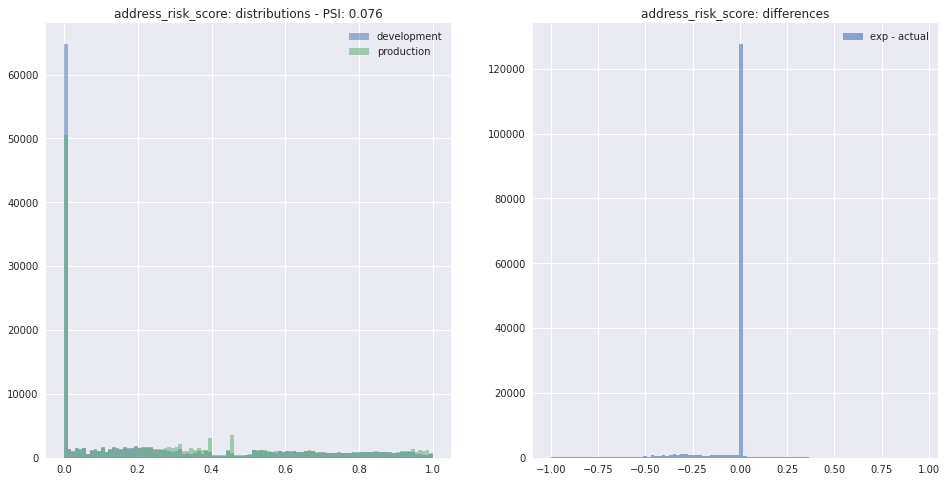

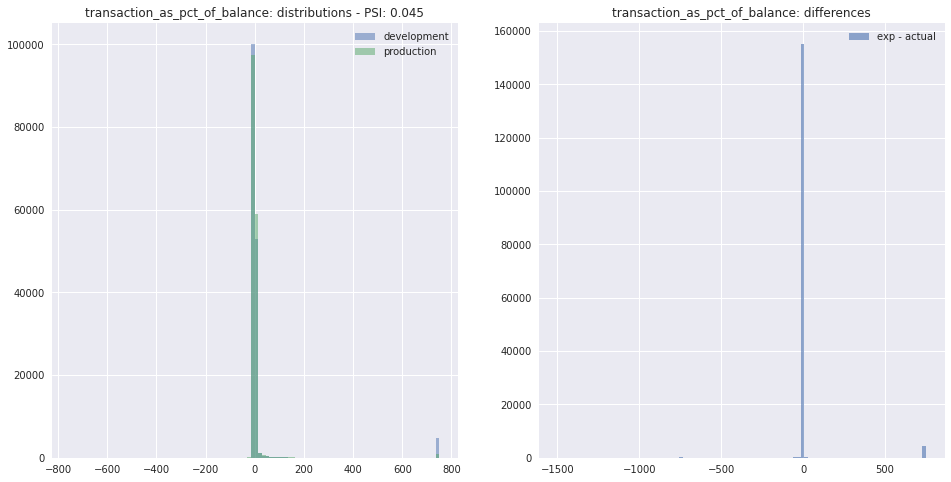

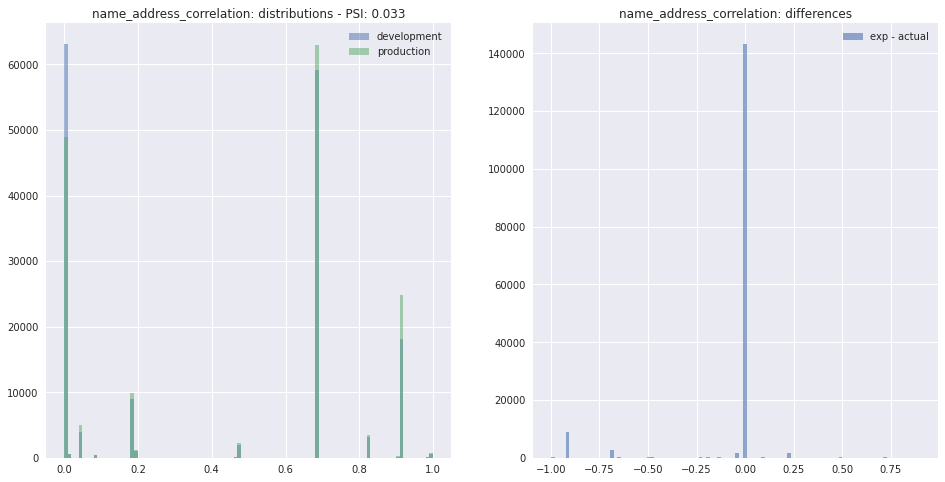

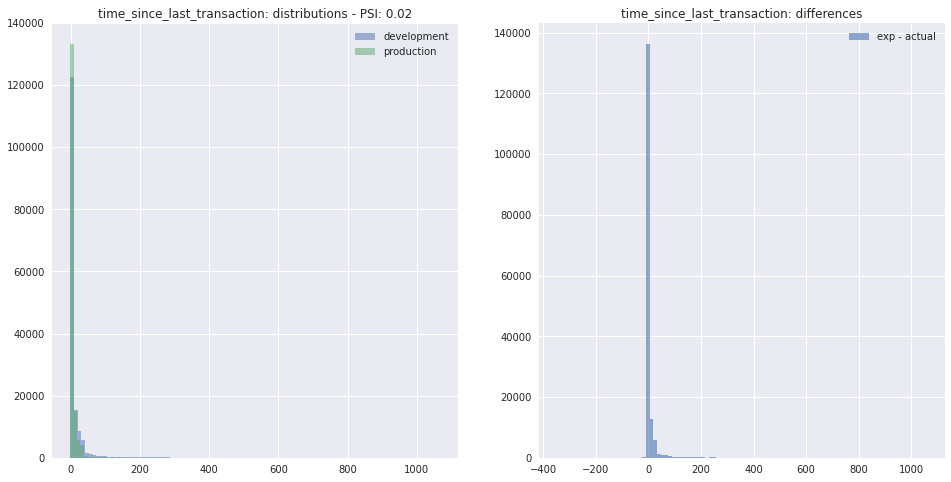

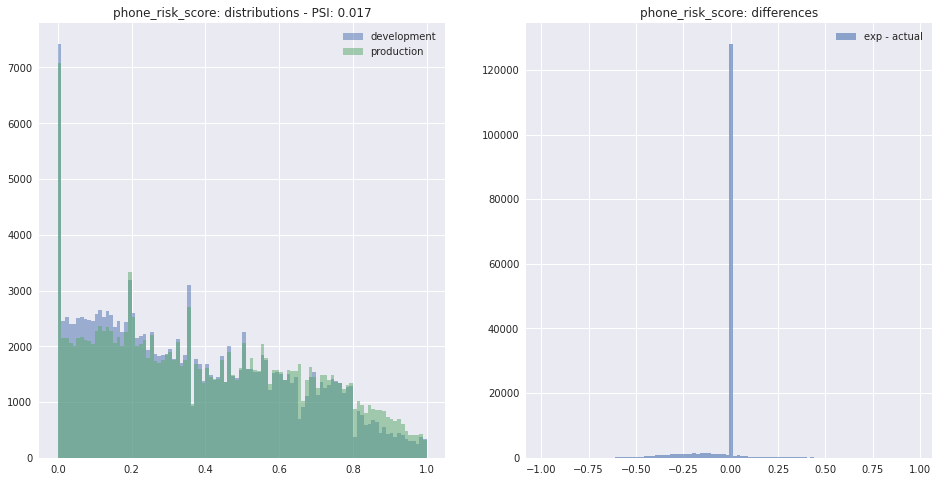

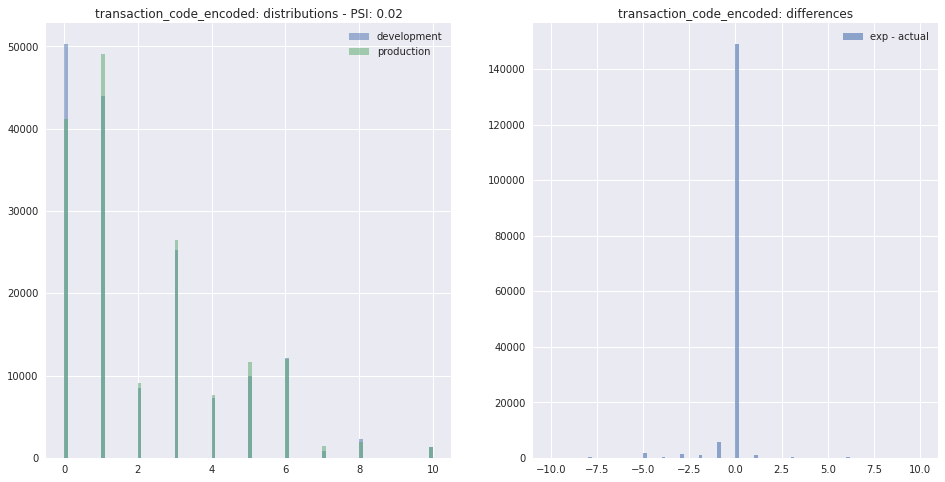

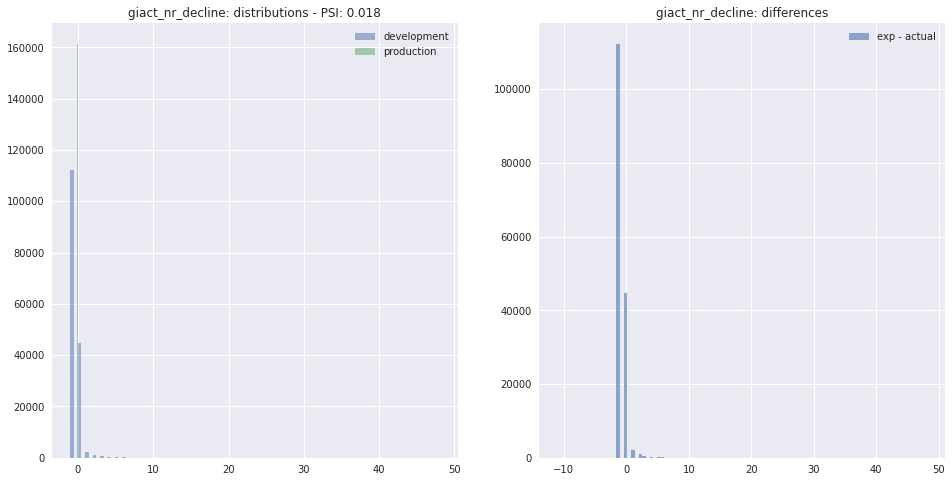

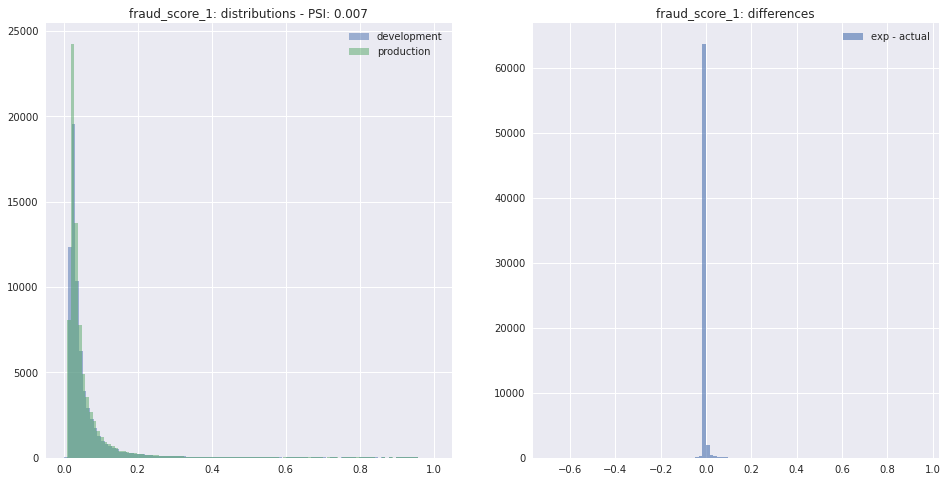

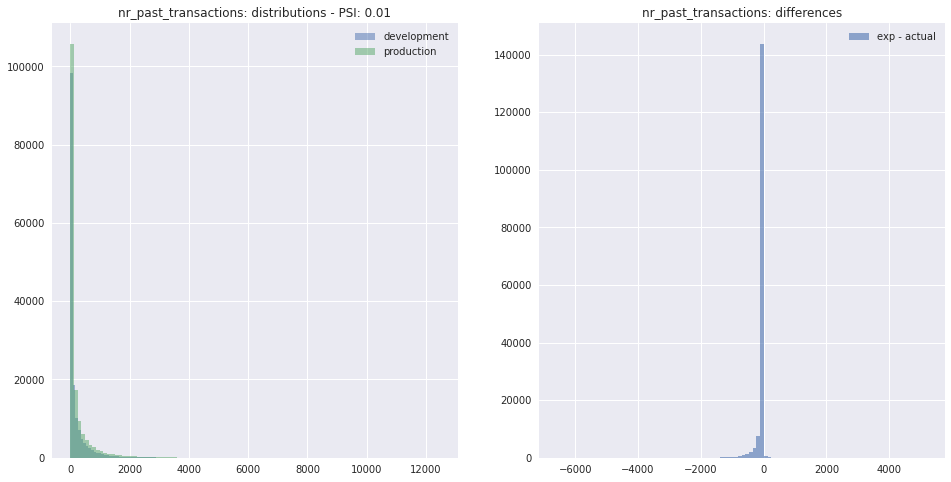

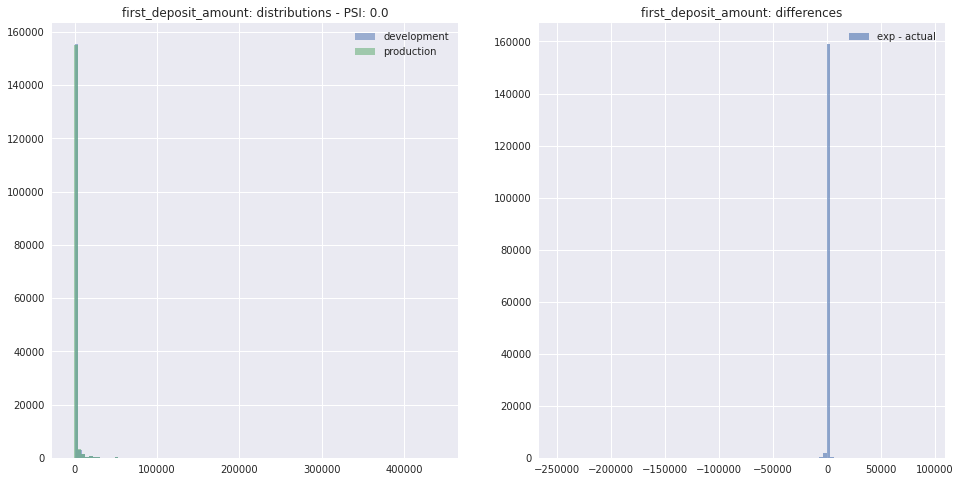

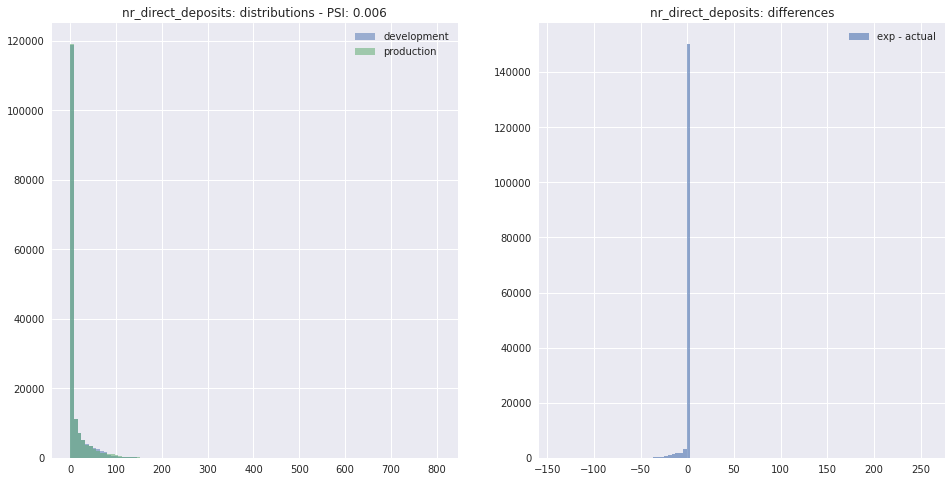

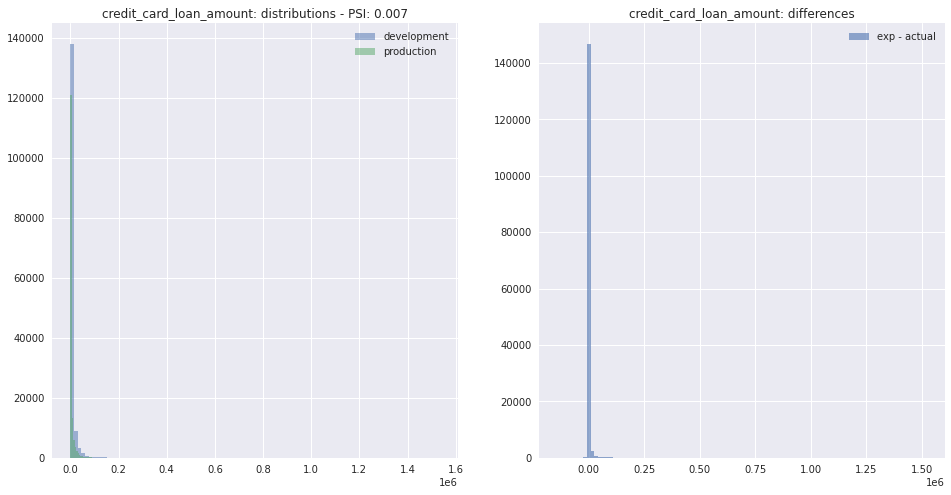

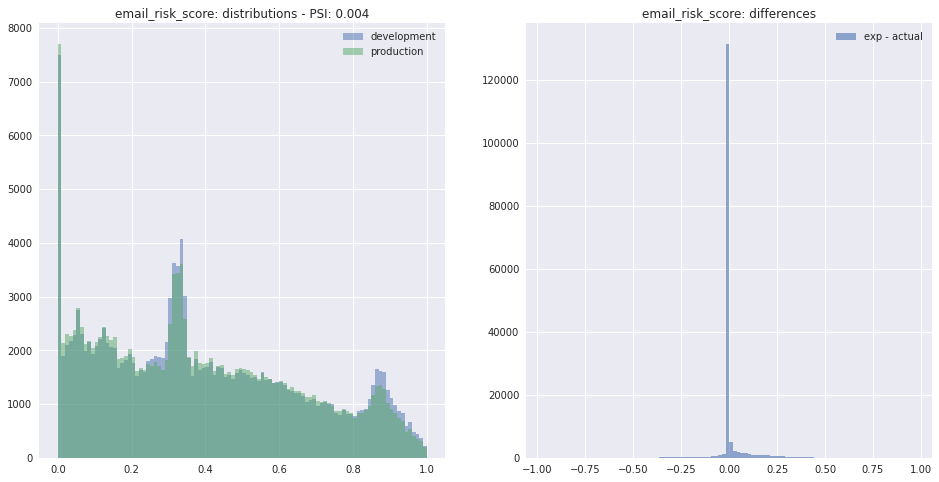

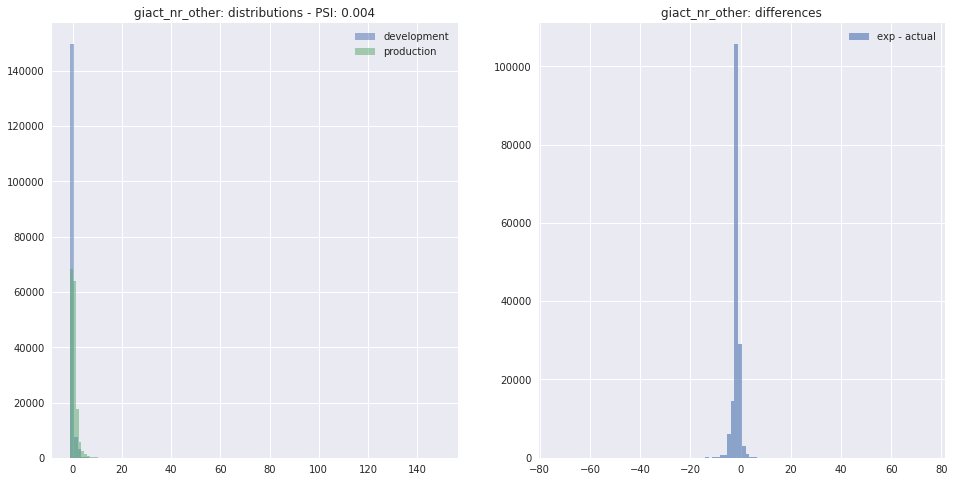

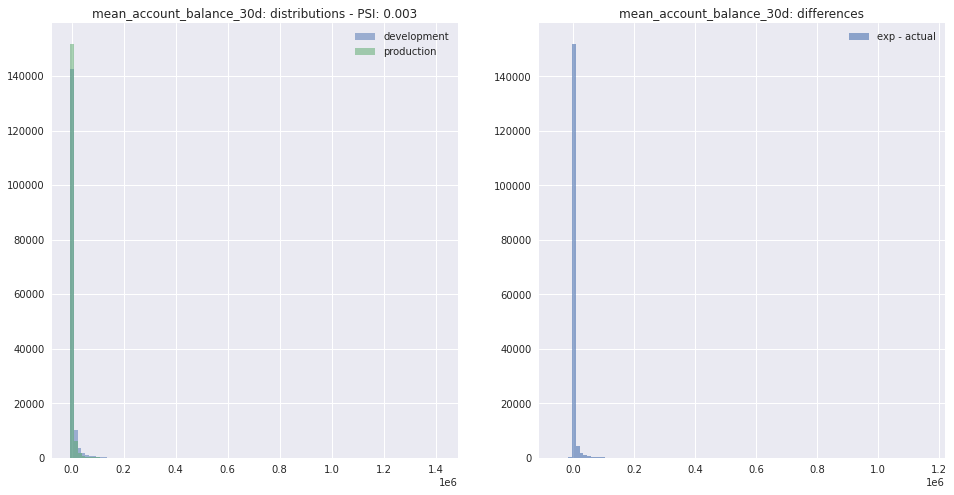

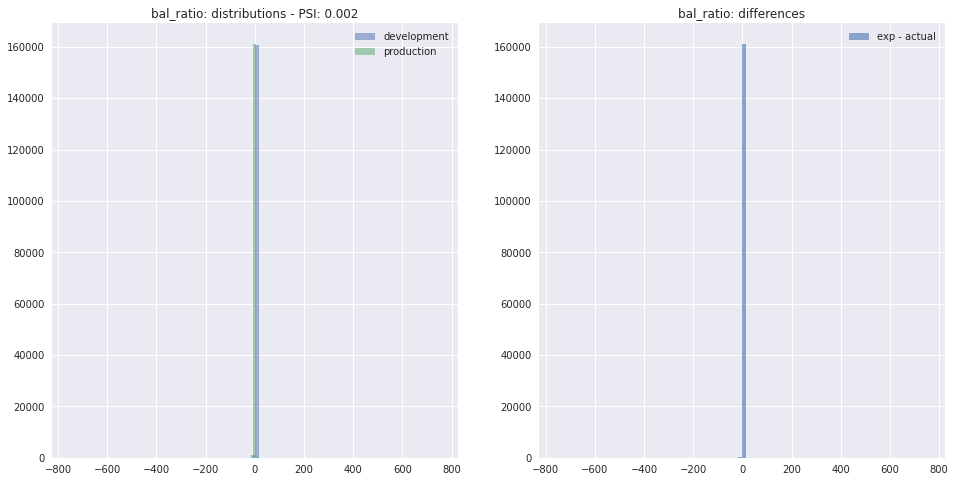

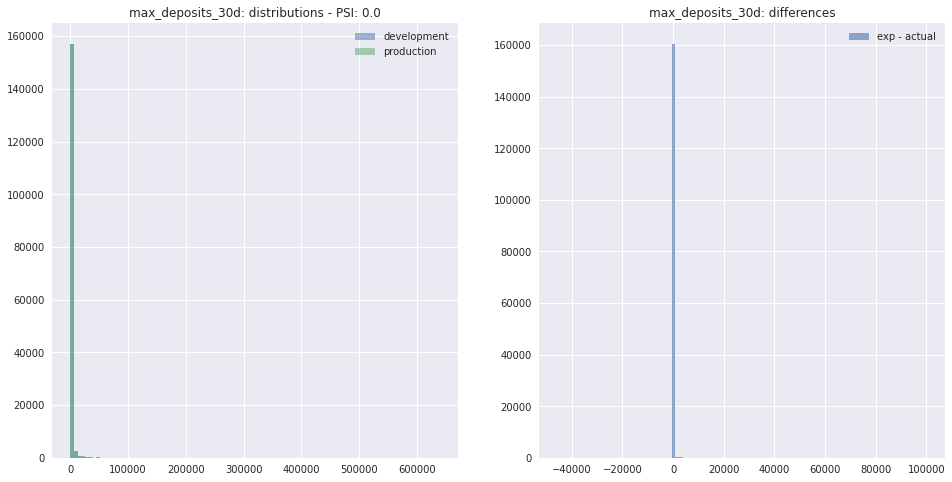

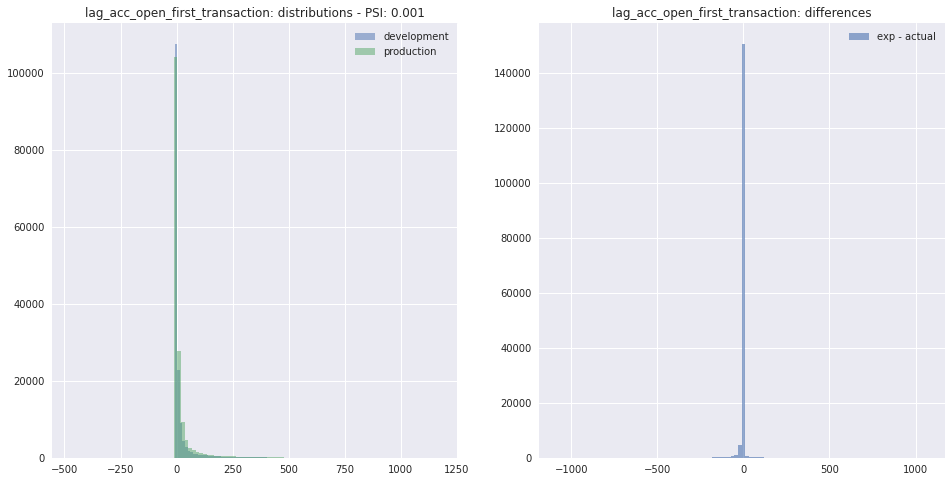

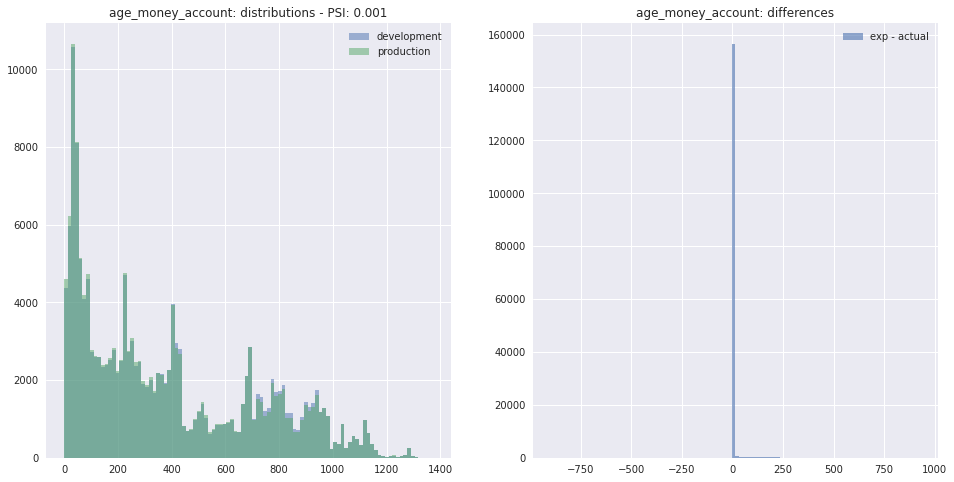

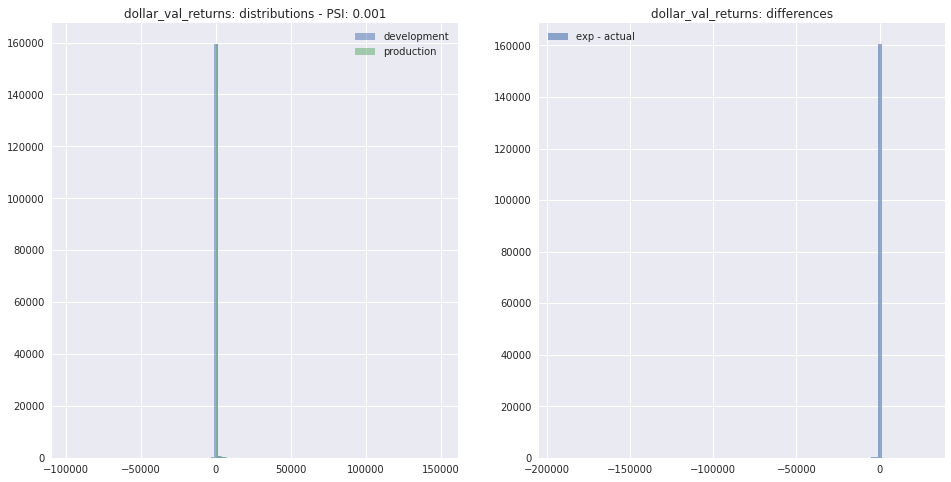

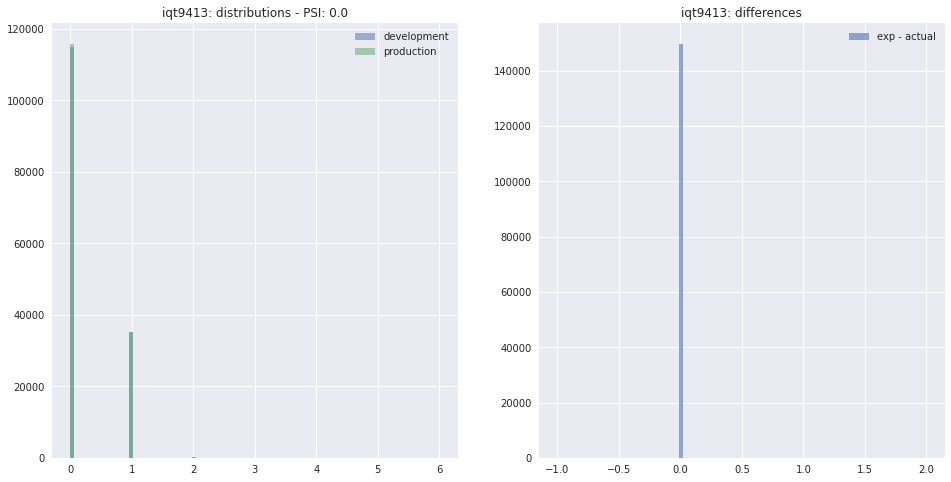

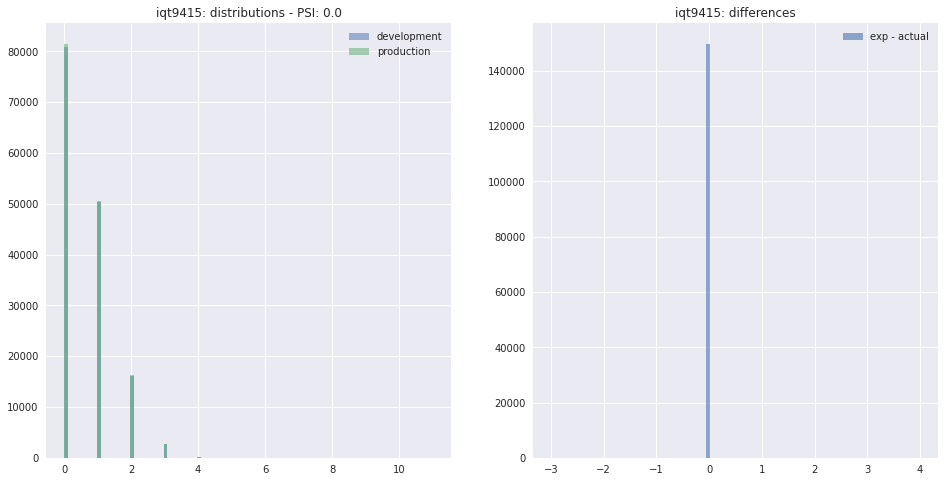

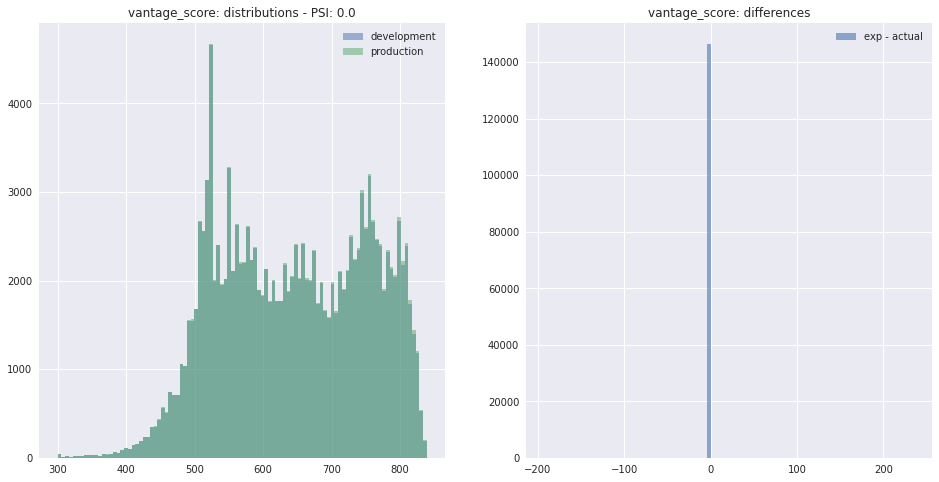

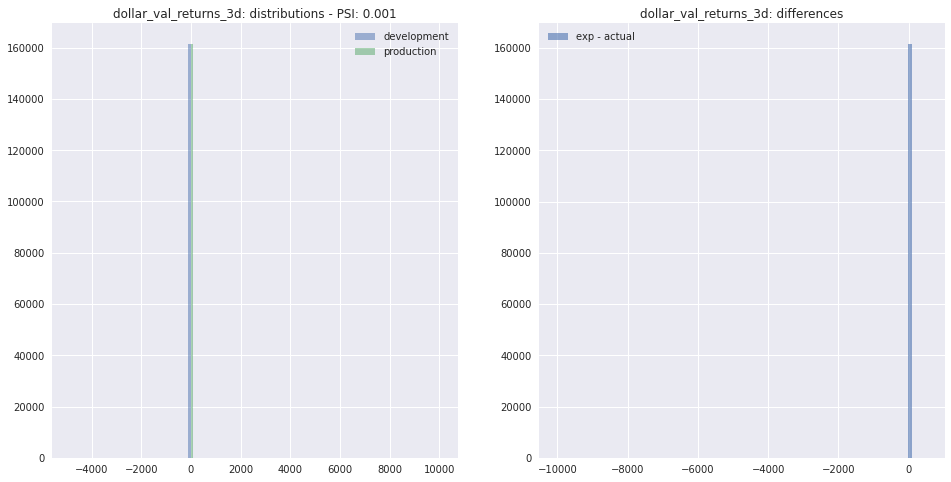

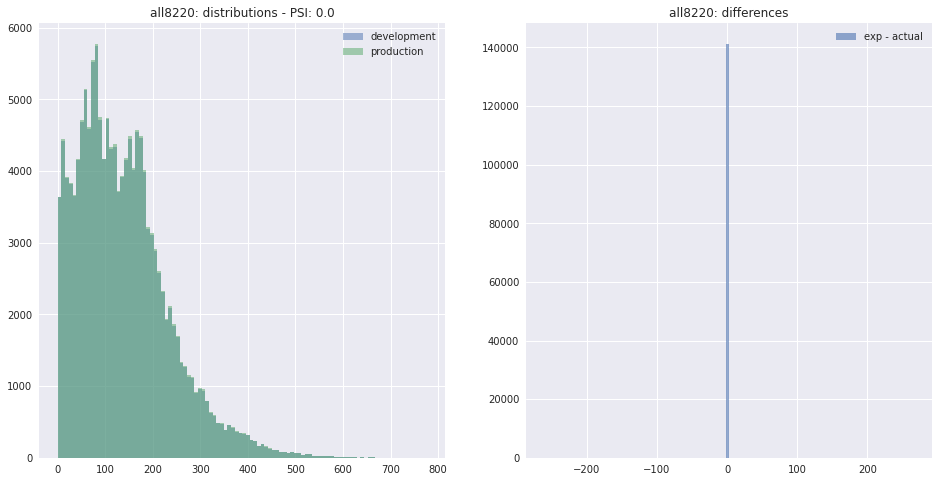

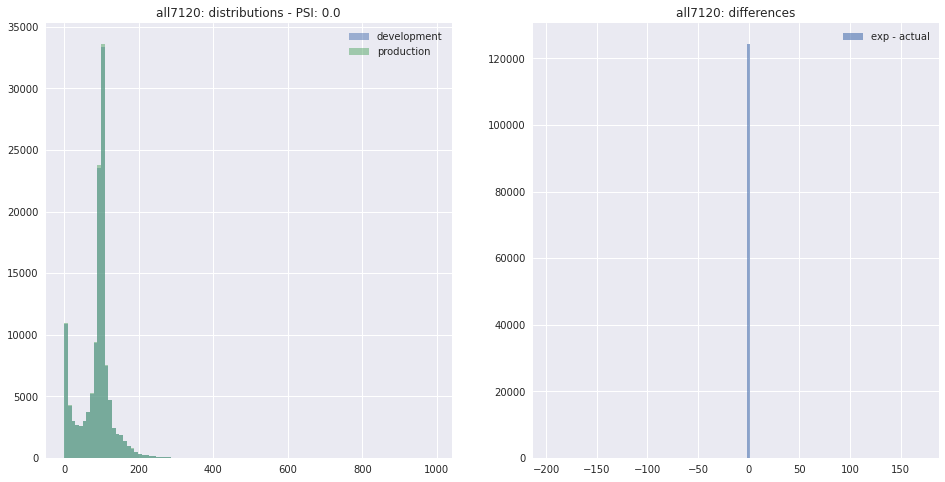

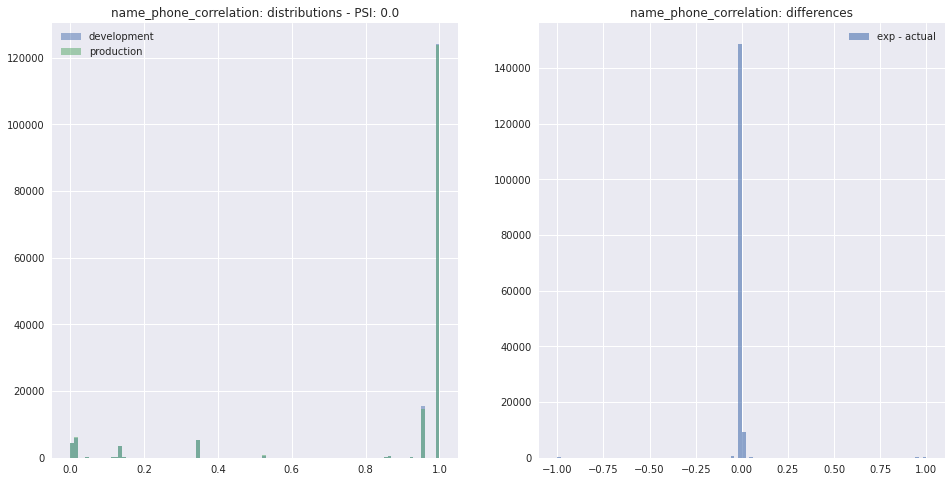

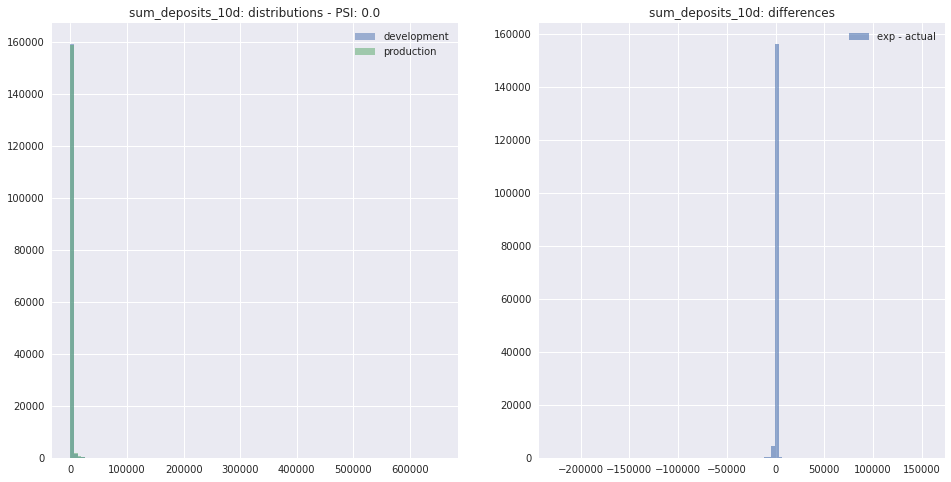

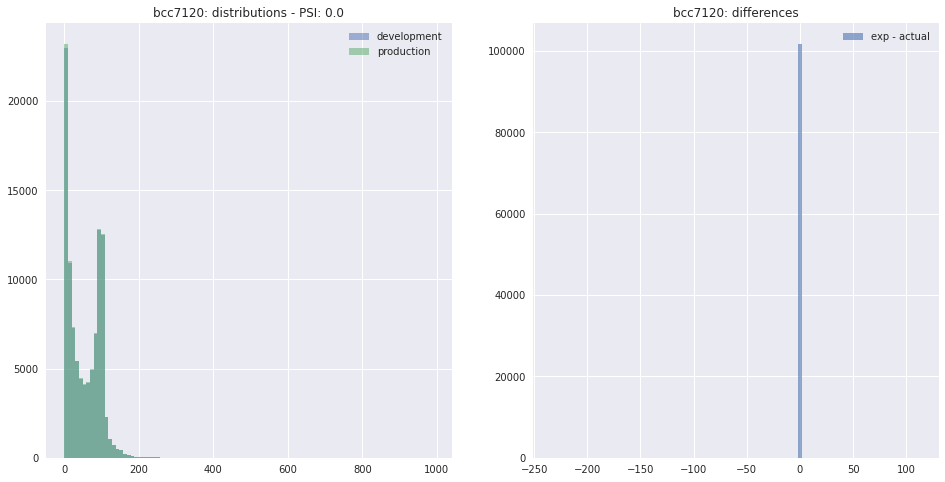

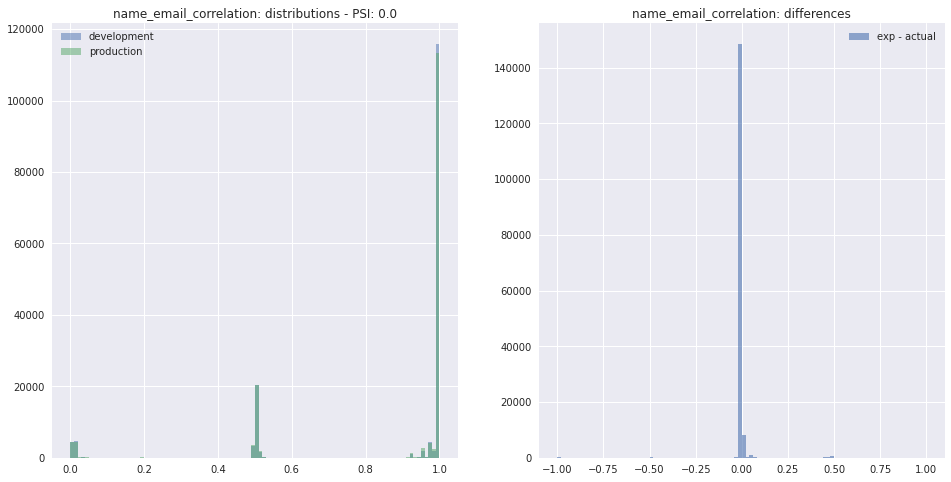

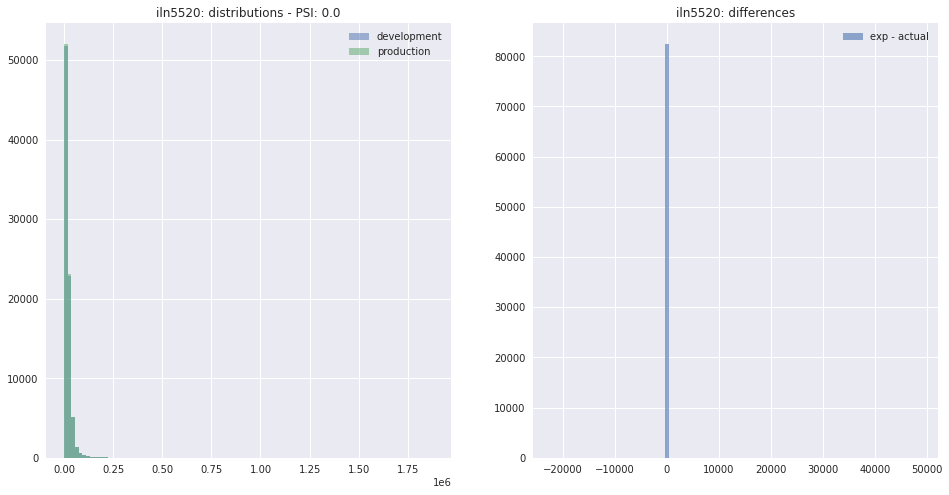

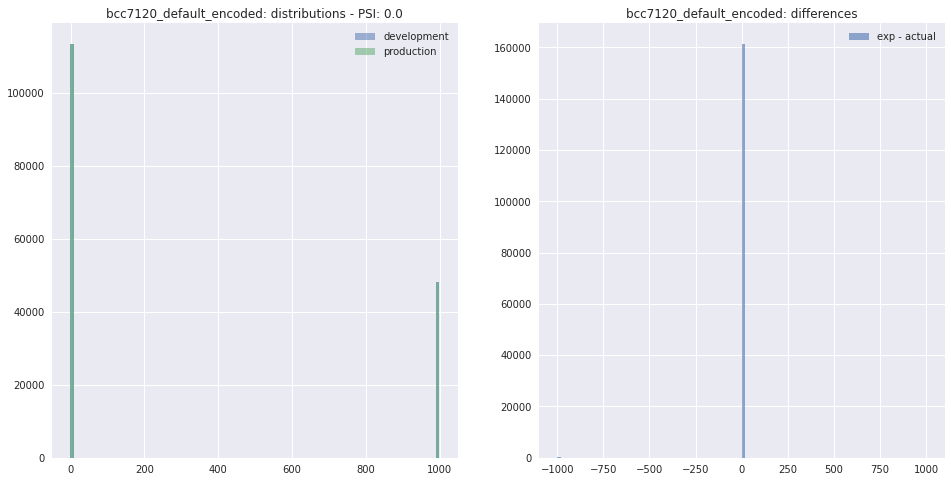

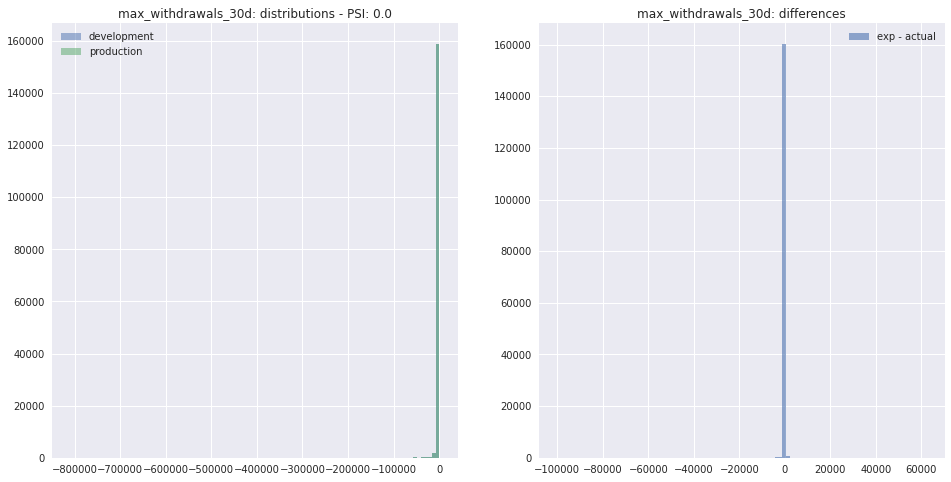

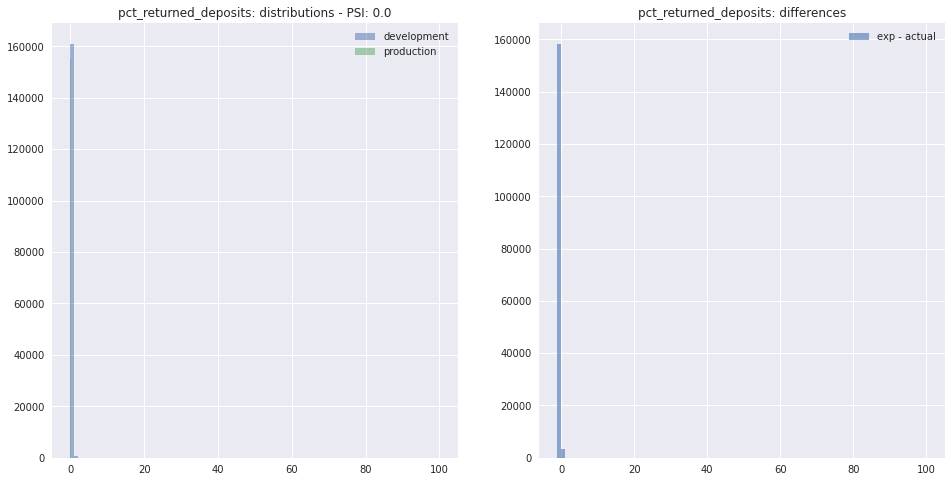

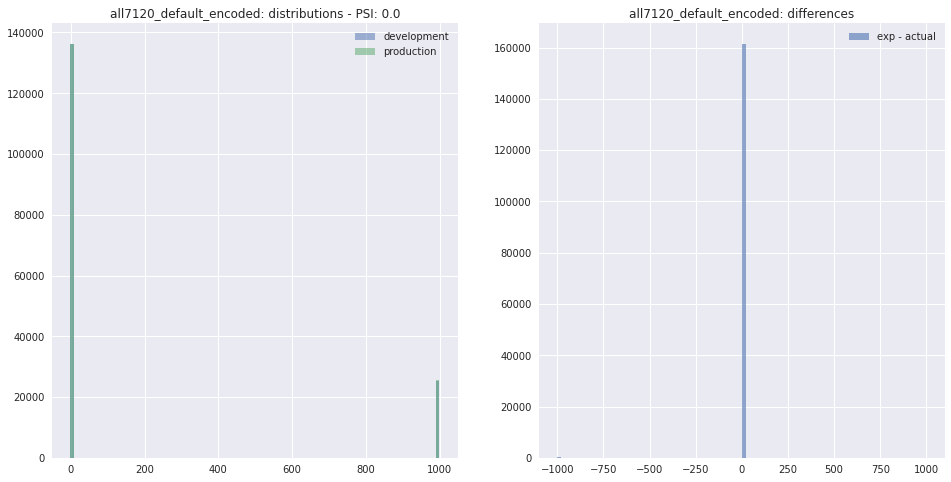

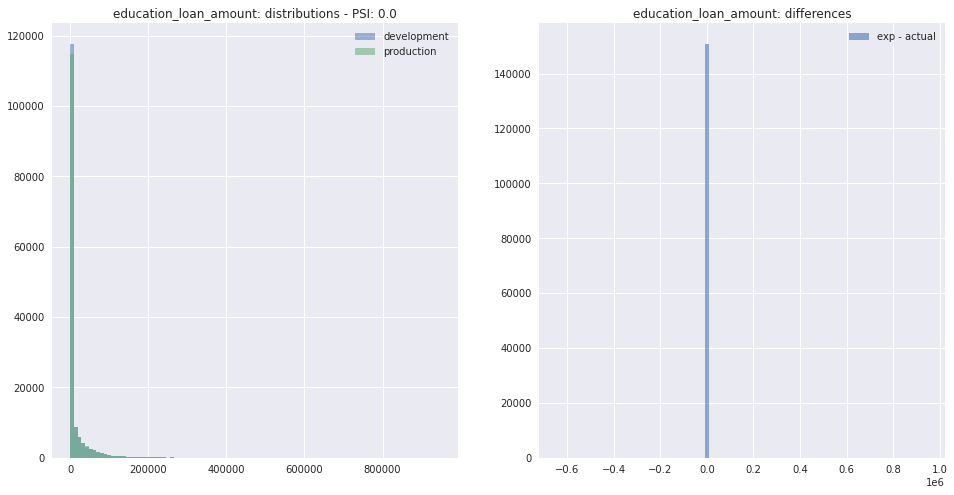

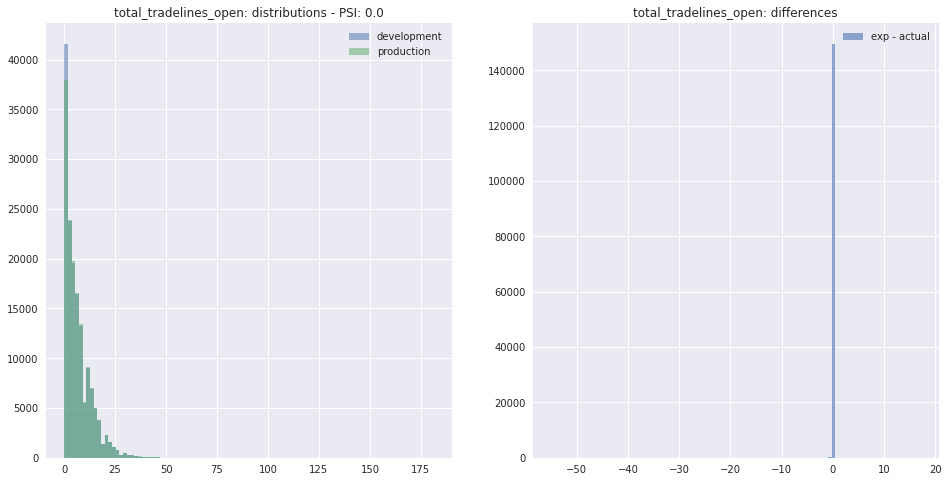

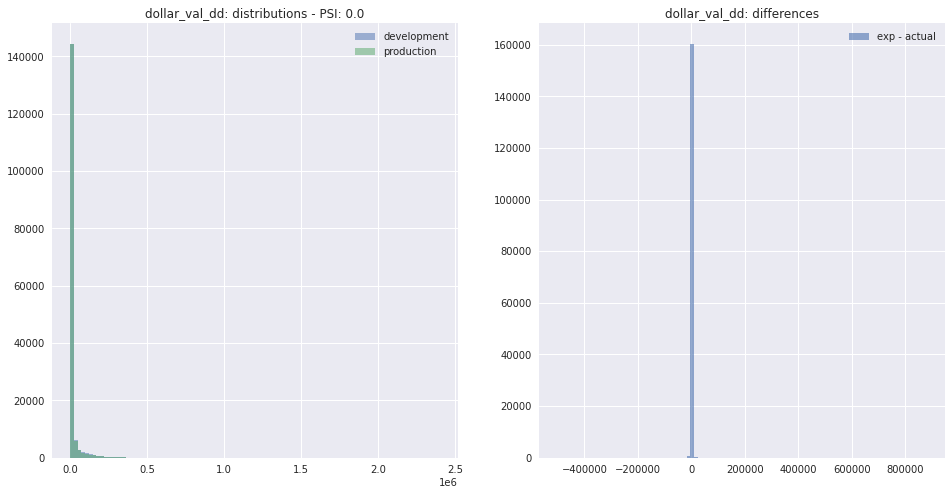

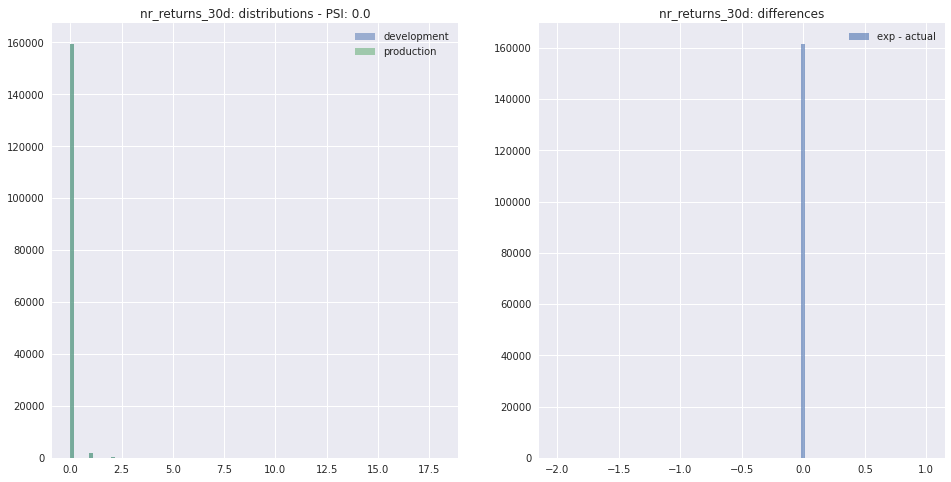

In [84]:
# all
for ft in psi_tbl_active.feature:
    ft_dev = ft + "_exp"
    ft_prod = ft + "_act"

    psi = get_psi(combined_df_active[ft_dev].rename().to_frame(), 
                             combined_df_active[ft_prod].rename().to_frame()).loc[0, "psi"]
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plot_score_dist(combined_df_active[ft_dev], combined_df_active[ft_prod], bins=100, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 3)}")
    plot_difference(combined_df_active[ft_dev], combined_df_active[ft_prod], bins=100, fig=fig, ax=axs[1], title=f"{ft}: differences") 
    plt.legend()